In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install bayesian-optimization
!pip install color-it
#!pip install dgl -f https://data.dgl.ai/wheels/repo.html
#!pip install dgl-cu111 dglgo -f https://data.dgl.ai/wheels/repo.html
#!pip install dive-into-graphs
#!pip install pydig

1.13.1+cu116
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from colorit import *
from torch._C import dtype

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import torch_geometric.nn as gnn
import torch.nn.functional as F
from torch.nn import Linear
from sklearn.model_selection import train_test_split
import numpy as np
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.data.batch import Batch
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from typing import Callable, Union, Tuple
from torch_sparse import SparseTensor
import itertools


from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn import metrics
from bayes_opt import BayesianOptimization, UtilityFunction


#. DGL
#import dgl
#import dgl.function as fn
#from dgl.data import GINDataset
#from dgl.nn import GNNExplainer as GNNExplainer_DGL
#from dgl.dataloading import GraphDataLoader
#from dgl.nn import AvgPooling

#. DIG
#from dig.xgraph.dataset import SynGraphDataset
#from dig.xgraph.method import PGExplainer
#from dig.xgraph.utils.compatibility import compatible_state_dict
#from dig.xgraph.method.subgraphx import PlotUtils
#from dig.xgraph.method.subgraphx import MCTS
#from torch_geometric.utils import to_networkx
#from dig.xgraph.method import GNNExplainer as GNNExplainer_DIG
#from dig.xgraph.models import GCN_2l
#from dig.xgraph.models import GlobalMeanPool

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Explainability_name = 'Evaluation of GNNs'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [ ]:
import csv
#                 #Dataset_name, Model_name, Model_Description, Weight_Initializer, num_folds, EPOCHS, lr, DropOut_Rate, Bias, Batch, Loss_Function, mean(AUC_ROC), mean(AUC_PRC), mean(ACC) 
Header = np.array(["Datset", "Model Name", "Model Description", "Weight_Initializer", "K-Fold", "Epochs", "LR", "DropOut Rate", "Bias", "Batch Size", "Loss Function", "AUC-ROC", "AUC-PRC", "Acc"])
with open("/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Experimental Results/HyperParameters.csv", 'w') as outcsv:
    writer = csv.DictWriter(outcsv, fieldnames = Header)
    writer.writeheader()

In [ ]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

In [ ]:
print("Number of Graphs: ", len(dataset))
print("Number of Node Features: ", dataset.num_node_features)
print("Number of Edge Features: ", dataset.num_edge_features)
#print("Number of Node Features: ", dataset.num_node_attributes)
#print("Number of Node Features: ", dataset.num_edge_attributes)
print("Number of Classes: ", dataset.num_classes)
count=0
for i in range(len(dataset)):
    count = count + len(dataset[i].edge_index[0])
print("Number of Edges: ", count)
data = dataset[0]
print(data)
#print(dataset.labels)

Number of Graphs:  188
Number of Node Features:  7
Number of Edge Features:  4
Number of Classes:  2
Number of Edges:  7442
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


In [ ]:
def pick_your_graph(main_dataset, train_index_list, test_index_list):
    train_dataset = []
    test_dataset = []
    
    for index in train_index_list:
        train_dataset.append(main_dataset[index])
    for index in test_index_list:
        test_dataset.append(main_dataset[index])
    
    return train_dataset, test_dataset

In [ ]:
def batching_data(train_dataset, test_dataset, BATCH_SIZE):
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    return train_dataloader, test_dataloader

In [ ]:
def get_your_dataset(num_folds, dataset, Batch_count_by_16):
    Train_Datasets_Index = []
    Test_Datasets_Index = []
    #num_folds = 3

    kf = KFold(n_splits=num_folds, shuffle=True)
    for train_index, test_index in kf.split(dataset):
        Train_Datasets_Index.append(train_index.tolist())
        Test_Datasets_Index.append(test_index.tolist())

    for k in range(num_folds):
        exec(f'Train_Dataset{k+1}, Test_Dataset{k+1} = pick_your_graph(dataset, Train_Datasets_Index[k], Test_Datasets_Index[k])')

    Train_Datasets_Batched = []
    Test_Datasets_Batched = []
    Train_Datasets = []
    Test_Datasets = []


    if Batch_count_by_16 != 0:
        for i in range(num_folds):
            exec(f'Train_Dataset_Batched{i+1}, Test_Dataset_Batched{i+1} = batching_data(Train_Dataset{i+1}, Test_Dataset{i+1}, Batch_count_by_16*16)')  
        for i in range(num_folds):
            exec(f'Train_Datasets_Batched.append(Train_Dataset_Batched{i+1})')
            exec(f'Test_Datasets_Batched.append(Test_Dataset_Batched{i+1})')
        #print("get your data done")
        return Train_Datasets_Batched, Test_Datasets_Batched
    else:
        for i in range(num_folds):
            exec(f'Train_Datasets.append(Train_Dataset{i+1})')
            exec(f'Test_Datasets.append(Test_Dataset{i+1})')
        
        return Train_Datasets, Test_Datasets

In [ ]:
#num_folds = 3
#Train_Datasets, Test_Datasets = get_your_dataset(num_folds, dataset)

#for i in range(num_folds):
#  print(np.shape(Train_Datasets[i]), np.shape(Test_Datasets[i]))



In [ ]:
feat_size = dataset[0].x.shape[1]
print(feat_size)
#DGL_Model = Graph_Model(feat_size, dataset.gclasses)

7


# **GCN MODEL**

In [ ]:
class GNNPool(nn.Module):
    def __init__(self):
        super().__init__()

In [ ]:
class GlobalMeanPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return gnn.global_mean_pool(x, batch)

In [ ]:
class IdenticalPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return x

In [ ]:
class GNNBasic(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def arguments_read(self, *args, **kwargs):

        data: Batch = kwargs.get('data') or None

        if not data:
            if not args:
                assert 'x' in kwargs
                assert 'edge_index' in kwargs
                x, edge_index = kwargs['x'], kwargs['edge_index'],
                batch = kwargs.get('batch')
                if batch is None:
                    batch = torch.zeros(kwargs['x'].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 2:
                x, edge_index = args[0], args[1]
                batch = torch.zeros(args[0].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 3:
                x, edge_index, batch = args[0], args[1], args[2]
            else:
                raise ValueError(f"forward's args should take 2 or 3 arguments but got {len(args)}")
        else:
            x, edge_index, batch = data.x, data.edge_index, data.batch

        return x, edge_index, batch


In [ ]:
class GCNConv(gnn.GCNConv):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_weight = None
        self.weight = nn.Parameter(self.lin.weight.data.T.clone().detach())

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize and edge_weight is None:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    edge_index, edge_weight = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    edge_index = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        edge_weight.requires_grad_(True)

        x = torch.matmul(x, self.weight)

        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        if self.bias is not None:
            out += self.bias

        self.edge_weight = edge_weight

        return out

    def propagate(self, edge_index: Adj, size: Size = None, **kwargs):
        size = self.__check_input__(edge_index, size)

        # Run "fused" message and aggregation (if applicable).
        if (isinstance(edge_index, SparseTensor) and self.fuse
                and not self._explain):
            coll_dict = self.__collect__(self.__fused_user_args__, edge_index,
                                         size, kwargs)

            msg_aggr_kwargs = self.inspector.distribute(
                'message_and_aggregate', coll_dict)
            out = self.message_and_aggregate(edge_index, **msg_aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)

        elif isinstance(edge_index, Tensor) or not self.fuse:
            coll_dict = self.__collect__(self.__user_args__, edge_index, size,
                                         kwargs)

            msg_kwargs = self.inspector.distribute('message', coll_dict)
            out = self.message(**msg_kwargs)

            if self._explain:
                edge_mask = self.__edge_mask__
                if out.size(self.node_dim) != edge_mask.size(0):
                    loop = edge_mask.new_ones(size[0])
                    edge_mask = torch.cat([edge_mask, loop], dim=0)
                assert out.size(self.node_dim) == edge_mask.size(0)
                out = out * edge_mask.view([-1] + [1] * (out.dim() - 1))

            aggr_kwargs = self.inspector.distribute('aggregate', coll_dict)
            out = self.aggregate(out, **aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)


In [ ]:
class GCN_2l_Model(GNNBasic):

    def __init__(self, model_level, dim_node, dim_hidden, dim_output, dropout_rate, Bias, Weight_Initializer):
        super().__init__()
        num_layer = 2

        self.gconv1 = GCNConv(dim_node, dim_hidden, bias=Bias)
        self.relu1 = nn.ReLU() 
        
        self.gconv2 = GCNConv(dim_hidden, dim_hidden, bias=Bias)
        self.relu2 = nn.ReLU()

        if model_level == 'node':
            self.readout = IdenticalPool()
        else:
            self.readout = GlobalMeanPool()

        self.ffn = nn.Linear(dim_hidden, dim_output, bias=Bias)

        self.dropout = nn.Dropout(p=dropout_rate)
        self.initialize_weights(Weight_Initializer, Bias)

    def initialize_weights(model, Weight_Initializer, Bias):
      # 1. Xavier Uniform.  2. Kaiming.  3. uniform (0,0.1std)
      if Weight_Initializer == 1:
          for m in model.modules():
                if isinstance(m, (nn.Linear)):
                    nn.init.xavier_normal_(m.weight)
                    if Bias:
                        m.bias.data.zero_()
                        #print("done")
                if isinstance(m, (GCNConv)):
                    nn.init.xavier_normal_(m.weight)
                    if Bias:
                        m.bias.data.zero_()
                        #print("here")

      if Weight_Initializer == 2:
        for m in model.modules():
            if isinstance(m, (nn.Linear)):
                nn.init.kaiming_normal_(m.weight)
                if Bias:
                    m.bias.data.zero_()
                    #print("done")
            if isinstance(m, (GCNConv)):
                nn.init.kaiming_normal_(m.weight)
                if Bias:
                    m.bias.data.zero_()
                    #print("here")

      if Weight_Initializer == 3:
          for m in model.modules():
              if isinstance(m, (nn.Linear)):
                  nn.init.normal_(m.weight.data, 0.0, 0.1)
                  if Bias:
                      m.bias.data.zero_()
                      print("done")
              if isinstance(m, (GCNConv)):
                  nn.init.normal_(m.weight.data, 0.0, 0.1)
                  if Bias:
                      m.bias.data.zero_()
                      #print("here")

    def forward(self, *args, **kwargs) -> torch.Tensor:
        """
        :param Required[data]: Batch - input data
        :return:
        """
        x, edge_index, batch = self.arguments_read(*args, **kwargs)

        post_conv1 = self.relu1(self.gconv1(x, edge_index))
        post_conv1 = self.dropout(post_conv1)

        post_conv2 = self.relu2(self.gconv2(post_conv1, edge_index))
        post_conv2 = self.dropout(post_conv1)
        out_readout = self.readout(post_conv2, batch)

        #print(np.shape(out_readout))
        out = self.ffn(out_readout)

        return out, post_conv2, post_conv1


    def get_emb(self, *args, **kwargs) -> torch.Tensor:
        x, edge_index, batch = self.arguments_read(*args, **kwargs)
        
        post_conv1 = self.relu1(self.gconv1(x, edge_index))
        post_conv2 = self.relu2(self.gconv2(x, edge_index))
            
        return post_conv2

In [ ]:
#def initialize_weights(model):
#  # Initializes weights according to the DCGAN paper
#  for m in model.modules():
#    if isinstance(m, (nn.Linear)):
#      nn.init.normal_(m.weight.data, 0.0, 0.01)
#      #print("done")
#    if isinstance(m, (GCNConv)):
#      #print("here")
#      nn.init.normal_(m.weight.data, 0.0, 0.01)

In [ ]:
def Models_K_Folds(num_folds, dataset, dropout_rate, Bias, winit):
    Models = []
    for i in range(num_folds):
        exec(f'GCN_Model_{i+1} = GCN_2l_Model(model_level="graph", dim_node=feat_size, dim_hidden=feat_size, dim_output=dataset.num_classes, dropout_rate=dropout_rate, Bias=Bias, Weight_Initializer= winit)')
        exec(f'Models.append(GCN_Model_{i+1})')
        #exec(f'initialize_weights(GCN_Model_{i+1})')
    
    #exec(f'print(GCN_Model_{1})')
    #exec(f'out, post_conv2, post_conv1 = GCN_Model_{1}(dataset[0].x, dataset[0].edge_index, dataset[0].batch)')
    #exec(f'print(out)')
    #GCN_Model_1.eval()

    #out1, post_conv2, post_conv1 = GCN_Model_1(dataset[0].x, dataset[0].edge_index, dataset[0].batch)
    #print(out)

    return Models

In [ ]:
#Models = Models_K_Folds(3, dataset, 0.5, True, 1)
#net = GCN_2l_Model(model_level="graph", dim_node=feat_size, dim_hidden=feat_size, dim_output=dataset.num_classes, dropout_rate=0.5, Bias=True, Weight_Initializer=1)

#initialize_weights(net)
#print(len(Models))

In [ ]:
def Optimizers_K_Fold_and_LR(models, num_folds, lr):
    Optimizers = []
    for i in range(num_folds):
        exec(f'GCN_Model_Optimizer_{i+1} = torch.optim.Adam(models[i].parameters(), lr=lr)')
        exec(f'Optimizers.append(GCN_Model_Optimizer_{i+1})')
    return Optimizers

In [ ]:
x = torch.rand(10).reshape(2, 5).float()
print(x)
#print(torch.tensor_split(x, 2, dim=1)[0])
logits = F.log_softmax(x, dim=0)
print(logits)
prob = F.softmax(logits, dim=0)


print(prob[0])
print(prob[1])

tensor([[0.0440, 0.1401, 0.8873, 0.2173, 0.2019],
        [0.6807, 0.1320, 0.2035, 0.1533, 0.3515]])
tensor([[-1.0613, -0.6891, -0.4086, -0.6617, -0.7708],
        [-0.4246, -0.6972, -1.0924, -0.7257, -0.6211]])
tensor([0.3460, 0.5020, 0.6646, 0.5160, 0.4627])
tensor([0.6540, 0.4980, 0.3354, 0.4840, 0.5373])


In [ ]:
CrossEnt_criterion = torch.nn.CrossEntropyLoss()
MAE_criterion = torch.nn.L1Loss()
MSE_criterion = torch.nn.MSELoss()

def loss_calculations(preds, gtruth, Loss_Function):
    #print("main: ", preds)
    #print(preds.shape)
    predss = torch.tensor_split(preds.reshape(len(preds), 2), 2, dim=1)
    #print("splitted0: ", preds[0])
    #print("splitted1: ", preds[1])
    if Loss_Function == 1:
        loss_per_epoch1 = CrossEnt_criterion(preds, gtruth).float()
        #print(loss_per_epoch1)
        return loss_per_epoch1

    elif Loss_Function == 2:
        loss_per_epoch2 = MAE_criterion(predss[1], gtruth).float()
        return loss_per_epoch2

    elif Loss_Function == 3:
        preds = preds.float()
        gtruth = gtruth.float()
        loss_per_epoch3 = MSE_criterion(predss[1], gtruth).float()
        #print("This is the Loss: ", loss_per_epoch3)
        return loss_per_epoch3

In [ ]:
def loading_model(load_index):
    GCN_Model = GCN_2l_Model(model_level='graph', dim_node=feat_size, dim_hidden=feat_size, dim_output=dataset.num_classes)
    GCN_Model_Optimizer = torch.optim.Adam(params = GCN_Model.parameters(), lr=0.001)
    checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
    GCN_Model.load_state_dict(checkpoint['model_state_dict'])
    GCN_Model.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']


    return GCN_Model, GCN_Model_Optimizer, epoch

In [ ]:
def visualize_losses(gcn_losses, epoch_history):
    gcn_losses_list = torch.stack(gcn_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("`GCN Model Loss in Epoch: " + str(epoch_history))
    ax.plot(gcn_losses_list, color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()  

# **Training Configurations**

In [ ]:
def train_step(GCN_Model, Optimizer, Data, Loss_Function):
    GCN_Model_loss_batch = []

    GCN_Model.train()
    GCN_Model.zero_grad()
    for graph in Data:
        gcn_model_output, post_conv2, post_conv1 = GCN_Model(graph.x, graph.edge_index, graph.batch)
        #print("before losss")
        batch_loss = loss_calculations(gcn_model_output, graph.y, Loss_Function)
        #print("loss is passed")
        GCN_Model_loss_batch.append(batch_loss)

        batch_loss.backward()
        Optimizer.step()
        
    
    return torch.mean(torch.tensor(GCN_Model_loss_batch))

In [ ]:
LOSS_Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [ ]:
def train(EPOCHS, load_index, GCN_Model, Optimizer, Data, Loss_Function):
    GCN_Model_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        GCN_Model_training_loss= train_step(GCN_Model, Optimizer, Data, Loss_Function)
        print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GCN_Model_training_loss:.4f}')
        GCN_Model_training_loss_per_epoch.append(GCN_Model_training_loss)

        if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
            visualize_losses(GCN_Model_training_loss_per_epoch, epoch + load_index + 1)
        if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
            torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GCN_Model.state_dict(), 'optimizer_state_dict': Optimizer.state_dict(), 'loss': GCN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")
    
    
    
    return GCN_Model_training_loss_per_epoch

In [ ]:
def sig(predictions):
    Preds = []
    for i in range(len(predictions)):
        Preds.append([1/(1 + np.exp(-predictions[i][0])), 1/(1 + np.exp(-predictions[i][1]))])
    return Preds

In [ ]:
def Evaluations(y, pred):
    TPR_List = []
    FPR_List = []
    Precision_List = []
    NPV_List = []
    Acc_List = []
    F1Score_List = []

    threshold = np.linspace(1, 0, 10)
    
    for t in threshold:
        y_pred = np.zeros(y.shape[0])
        y_pred[pred >= t] = 1

        TN = y_pred[(y_pred == y) & (y == 0)].shape[0]
        TP = y_pred[(y_pred == y) & (y == 1)].shape[0]
        FP = y_pred[(y_pred != y) & (y == 0)].shape[0]
        FN = y_pred[(y_pred != y) & (y == 1)].shape[0]

        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        TNR = TN / (TN + FP)
        FNR = FN / (FN + TP)

        Precision = TP / (TP + FP + 1e-10)
        NPV = TN / (TN + FN + 1e-10)
        FDR = FP / (FP + TP + 1e-10)
        FOR = FN / (FN + TN + 1e-10)
        PLR = TPR / (FPR + 1e-10)
        NLR = FNR / (TNR + 1e-10)
        Acc = (TP + TN) / (TP + TN + FP + FN)
        F1Score = (2 * TP) / (2*TP + FP + FN)
        

        TPR_List.append(TPR)
        FPR_List.append(FPR)
        Precision_List.append(Precision)
        NPV_List.append(NPV)
        Acc_List.append(Acc)
        F1Score_List.append(F1Score)
    
    AUC_ROC = metrics.auc(FPR_List, TPR_List)
    AUC_ROC2 = metrics.roc_auc_score(y, pred)

    sorted_index_p = np.argsort(Precision_List)
    sorted_index_r = np.argsort(TPR_List)
    Precision_List =  np.array(Precision_List)[sorted_index_p]
    TPR_List = np.array(TPR_List)[sorted_index_r]
    AUC_PRC = metrics.auc(y=Precision_List, x=TPR_List)

    precision, recall, thresholds = metrics.precision_recall_curve(y, pred)
    sorted_index_p = np.argsort(precision)
    sorted_index_r = np.argsort(recall)
    precision =  np.array(precision)[sorted_index_p]
    recall = np.array(recall)[sorted_index_r]
    AUC_PRC2 = metrics.auc(y=precision, x=recall)
    ACC = metrics.accuracy_score(y, pred.round(), normalize=False)
    ACC2 = metrics.accuracy_score(y, pred.round(), normalize=True)

    return FPR_List, TPR_List, threshold, Precision_List, NPV_List, Acc_List, F1Score_List, AUC_ROC2, AUC_PRC2, ACC, ACC2

In [ ]:
def detaching(test_dataset, GCN_Outputs, Batch):
    GCN_Outputs = list(itertools.chain.from_iterable(GCN_Outputs))
    #test_dataset = list(itertools.chain.from_iterable(test_dataset))
    #print("preds: ", GCN_Outputs)

    #print("reals: ", len(next(iter(test_dataset))))
    if Batch == 0:
        Real_Labels = []
        for i in range(len(test_dataset)):
            Real_Labels.append(test_dataset[i].y[0].detach().tolist())
        
        predictions = sig(GCN_Outputs)
        Predicted_Labels = []
        for i in range(len(predictions)):
            Predicted_Labels.append(predictions[i][1])

        return Evaluations(np.array(Real_Labels), np.array(Predicted_Labels))
    else:
        Real_Labels=[]
        for btch in test_dataset:
            Real_Labels.extend(btch.y.cpu().detach().numpy())
        Predicted_Labels = []
        for i in range(len(GCN_Outputs)):
            Predicted_Labels.append(GCN_Outputs[i][1])
        #print(Real_Labels)
        #print(Predicted_Labels)
        return Evaluations(np.array(Real_Labels), np.array(Predicted_Labels))

In [ ]:
def GCN_Model_Evaluation(test_dataset, GCN_Model, Batch):
    GCN_Outputs = []
    GCN_Preds = []
    GCN_Outputs_Batched = []
    GCN_Preds_Batched = []

    GCN_Model.eval()

    for batch_of_graphs in test_dataset:
        GCN_Model_test_activations, post_conv2_test_activations, post_conv1_test_activations = GCN_Model(batch_of_graphs.x, batch_of_graphs.edge_index, batch_of_graphs.batch)
        GCN_Model_test_pred = GCN_Model_test_activations.argmax(dim=1)
        
        if Batch == 0:
            GCN_Outputs.append(GCN_Model_test_activations[0].detach().tolist())  
            GCN_Preds.append(GCN_Model_test_pred.detach().tolist())
        else:
            GCN_Outputs_Batched.append(GCN_Model_test_activations.detach().tolist())  
            GCN_Preds_Batched.append(GCN_Model_test_pred.detach().tolist())
    if Batch == 0:
        return detaching(test_dataset, GCN_Outputs, Batch)
    else:
        return detaching(test_dataset, GCN_Outputs_Batched, Batch)

In [ ]:
#Dataset_name, Model_name, Model_Description, Weight_Initializer, num_folds, EPOCHS, lr, DropOut_Rate, Bias, Batch, Loss_Function, mean(AUC_ROC), mean(AUC_PRC), mean(ACC) 
def recording(config_list):
    if config_list[10] == 1:
        config_list[10] = "CrossEntropyLoss"
    elif config_list[10] == 2:
        config_list[10] = "MAE"
    elif config_list[10] == 3:
        config_list[10] = "MSE"

    if config_list[3] == 1:
        config_list[3] = "xavier_normal_"
    elif config_list[3] == 2:
        config_list[3] = "kaiming_normal_"
    elif config_list[3] == 3:
        config_list[3] = "normal_"
    
    with open("/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Experimental Results/HyperParameters.csv", 'a') as outcsv:
        wr = csv.writer(outcsv, dialect='excel', delimiter=',')
        wr.writerow(config_list)

In [ ]:
def Central_Room(Dataset_name, Model_name, num_folds, lr, EPOCHS, DropOut_Rate, Bias, Batch_count_by_16, Loss_Function, Weight_Initializer, load_index):  
    if Dataset_name == 1:
        Dataset_name="MUTAG"
    else: 
        Dataset_name="MUTAG"

    if Model_name == 1:
        Model_name= "GCN+GAP"
    else: 
        Model_name= "GCN+GAP"

    Train_Datasets, Test_Datasets = get_your_dataset(num_folds, dataset, Batch_count_by_16)
    Models = Models_K_Folds(num_folds, dataset, DropOut_Rate, Bias, Weight_Initializer)
    Optimizers = Optimizers_K_Fold_and_LR(Models, num_folds, lr)

    if load_index is not 0:
        GCN_Model, GCN_Model_Optimizer, load_index = loading_model(load_index)
    
    ACC = []
    ACC_counter = []
    AUC_ROC = []
    AUC_PRC = []


    for i in range(num_folds):
        train(EPOCHS, load_index, Models[i], Optimizers[i], Train_Datasets[i], Loss_Function)
        fpr, tpr, threshold, precision_list, npv_list, acc_list, f1score_list, auc_roc2, auc_prc2, acc, acc2 = GCN_Model_Evaluation(Test_Datasets[i], Models[i], Batch)
        ACC.append(acc2)
        ACC_counter.append(acc)
        AUC_ROC.append(auc_roc2)
        AUC_PRC.append(auc_prc2)

    #print("AUC_ROC: ", mean(AUC_ROC))
    #print("AUC_PRC: ", mean(AUC_PRC))
    #print("ACC: ", mean(ACC_counter), " out of ", len(Train_Datasets[0]))
    #print("ACC: ", mean(ACC))
    Model_Description = Models[0]
    recording([Dataset_name, Model_name, Model_Description, Weight_Initializer, num_folds, EPOCHS, lr, DropOut_Rate, Bias, Batch_count_by_16*16, Loss_Function, mean(AUC_ROC), mean(AUC_PRC), mean(ACC)])
    #Dataset_name, Model_name, Model_Description, Weight_Initializer, num_folds, EPOCHS, lr, DropOut_Rate, Bias, Batch, Loss_Function, mean(AUC_ROC), mean(AUC_PRC), mean(ACC)
    
    return AUC_ROC[-1]

<>:16: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:16: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-37-c8b638a69e41>:16: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if load_index is not 0:


In [ ]:
#Central_Room(Dataset_name="MUTAG", Model_name="GCN+GAP", num_folds=18, lr=0.001, EPOCHS=200, DropOut_Rate=0.25, Bias=True, Loss_Function="CrossEntropyLoss", Weight_Initializer="uniform", load_index=0)
#x = Central_Room(2)

In [ ]:
print(int(1.9))

1


In [ ]:
def Final_OutComes():
    print("Best result: {}; f(x) = {:.3f}.".format(optimizer.max["params"], optimizer.max["target"]))
    print()
    print()
    plt.figure(figsize = (15, 5))
    plt.plot(range(1, 1 + len(optimizer.space.target)), optimizer.space.target, "-o", color='red')
    plt.grid(True)
    plt.xlabel("Iteration", fontsize = 14)
    plt.ylabel("AUC-ROC f(x)", fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'AUC_ROC_BO_HyperParameter.png')
    plt.show()

In [ ]:
#Dataset_name, Model_name, Weight_Initializer, num_folds, lr, EPOCHS, DropOut_Rate, Bias, Batch, Loss_Function, Weight_Initializer, load_index

Dataset_name = [1, 1.99]   #.    "MUTAG"       For now Fixed
Model_name = [1, 1.99]   #.   "GCN+GAP"       For now Fixed
num_folds = [2, 4]
lr = [0.0001, 0.01]
EPOCHS = [1, 2.9]   #.  * 100       
DropOut_Rate = [0.25, 0.75]
Bias = [0, 1]
Batch = [1, 3.99] #. Batch_count_by_16
Loss_Function = [1, 3.9]   #.   "CrossEntropyLoss" add more for now
Weight_Initializer = [1, 3.9] # 1. Xavier Uniform.  2. Kaiming.  3. uniform 0,0.1std
load_index = [0, 0.9]   #.   "zero"






utility = UtilityFunction(kind = "ucb", kappa = 1.96, xi = 0.01)
param_grid = dict(Dataset_name=Dataset_name, Model_name=Model_name, num_folds=num_folds, lr=lr, EPOCHS=EPOCHS, DropOut_Rate=DropOut_Rate, Bias=Bias, Batch_count_by_16=Batch, Loss_Function=Loss_Function, Weight_Initializer=Weight_Initializer, load_index=load_index)


In [ ]:
optimizer = BayesianOptimization(f = None, pbounds = param_grid, verbose = 3,random_state = 4)

In [ ]:
def call_me_to_start(iterations):
    for i in range(iterations):
        # Get optimizer to suggest new parameter values to try using the
        # specified acquisition function.
        next_point = optimizer.suggest(utility)
        #print(next_point)
        # Force degree from float to int.
        next_point["Dataset_name"] = int(next_point["Dataset_name"])
        next_point["Model_name"] = int(next_point["Model_name"])
        next_point["num_folds"] = int(next_point["num_folds"])
        next_point["lr"] = float(next_point["lr"])
        next_point["EPOCHS"] = int(next_point["EPOCHS"]) * 100
        next_point["DropOut_Rate"] = float(next_point["DropOut_Rate"])
        next_point["Bias"] = bool(round(next_point["Bias"]))
        next_point["Batch_count_by_16"] = int(next_point["Batch_count_by_16"])
        next_point["Loss_Function"] = int(next_point["Loss_Function"])
        next_point["Weight_Initializer"] = int(next_point["Weight_Initializer"])
        next_point["load_index"] = int(next_point["load_index"])

        print(next_point)

        #break
        # Evaluate the output of the black_box_function using 
        # the new parameter values.
        target = Central_Room(**next_point)
        try:
            # Update the optimizer with the evaluation results. 
            # This should be in try-except to catch any errors!
            optimizer.register(params = next_point, target = target)
        except:
            pass
        print(color('===========================================================================================================', Colors.purple))
        print(color(f'iTeration: {i+1:03d} is Passed!', Colors.red))
    Final_OutComes()

{'Batch_count_by_16': 1, 'Bias': True, 'Dataset_name': 1, 'DropOut_Rate': 0.33192112070234936, 'EPOCHS': 200, 'Loss_Function': 1, 'Model_name': 1, 'Weight_Initializer': 1, 'load_index': 0, 'lr': 0.004417851804109998, 'num_folds': 3}
Epoch: 001, Evaluation of GNNs Model Loss: 0.6109
Epoch: 002, Evaluation of GNNs Model Loss: 0.5997
Epoch: 003, Evaluation of GNNs Model Loss: 0.6363
Epoch: 004, Evaluation of GNNs Model Loss: 0.6191
Epoch: 005, Evaluation of GNNs Model Loss: 0.5926
Epoch: 006, Evaluation of GNNs Model Loss: 0.6344
Epoch: 007, Evaluation of GNNs Model Loss: 0.6065
Epoch: 008, Evaluation of GNNs Model Loss: 0.6204
Epoch: 009, Evaluation of GNNs Model Loss: 0.5962
Epoch: 010, Evaluation of GNNs Model Loss: 0.5996
Epoch: 011, Evaluation of GNNs Model Loss: 0.6006
Epoch: 012, Evaluation of GNNs Model Loss: 0.5948
Epoch: 013, Evaluation of GNNs Model Loss: 0.5709
Epoch: 014, Evaluation of GNNs Model Loss: 0.5729
Epoch: 015, Evaluation of GNNs Model Loss: 0.5843
Epoch: 016, Evalu

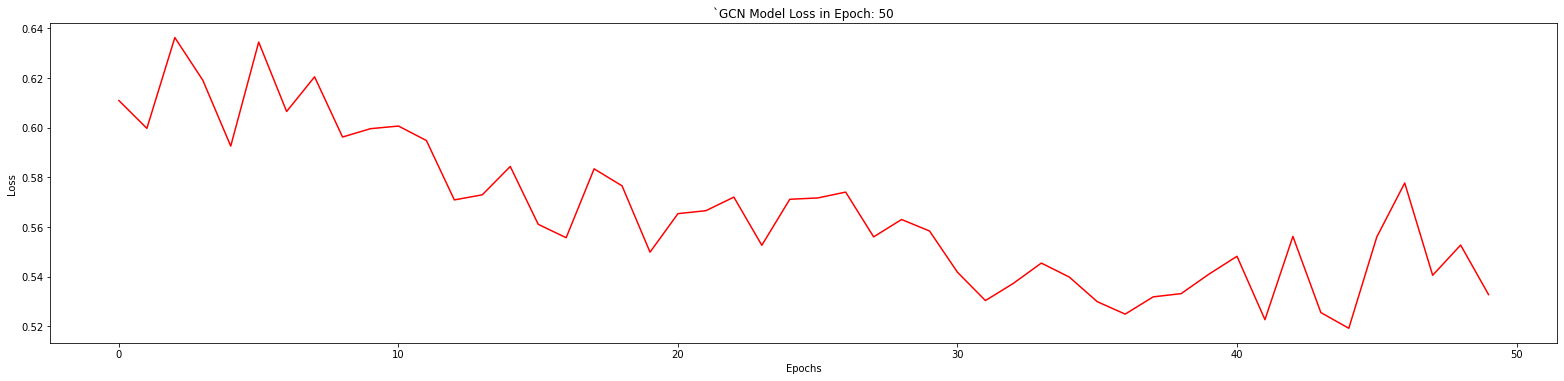

Epoch: 051, Evaluation of GNNs Model Loss: 0.5337
Epoch: 052, Evaluation of GNNs Model Loss: 0.5339
Epoch: 053, Evaluation of GNNs Model Loss: 0.5334
Epoch: 054, Evaluation of GNNs Model Loss: 0.5281
Epoch: 055, Evaluation of GNNs Model Loss: 0.5421
Epoch: 056, Evaluation of GNNs Model Loss: 0.5397
Epoch: 057, Evaluation of GNNs Model Loss: 0.5263
Epoch: 058, Evaluation of GNNs Model Loss: 0.5179
Epoch: 059, Evaluation of GNNs Model Loss: 0.5044
Epoch: 060, Evaluation of GNNs Model Loss: 0.5174
Epoch: 061, Evaluation of GNNs Model Loss: 0.5451
Epoch: 062, Evaluation of GNNs Model Loss: 0.5140
Epoch: 063, Evaluation of GNNs Model Loss: 0.5366
Epoch: 064, Evaluation of GNNs Model Loss: 0.5268
Epoch: 065, Evaluation of GNNs Model Loss: 0.5332
Epoch: 066, Evaluation of GNNs Model Loss: 0.5277
Epoch: 067, Evaluation of GNNs Model Loss: 0.5369
Epoch: 068, Evaluation of GNNs Model Loss: 0.5402
Epoch: 069, Evaluation of GNNs Model Loss: 0.5109
Epoch: 070, Evaluation of GNNs Model Loss: 0.5192


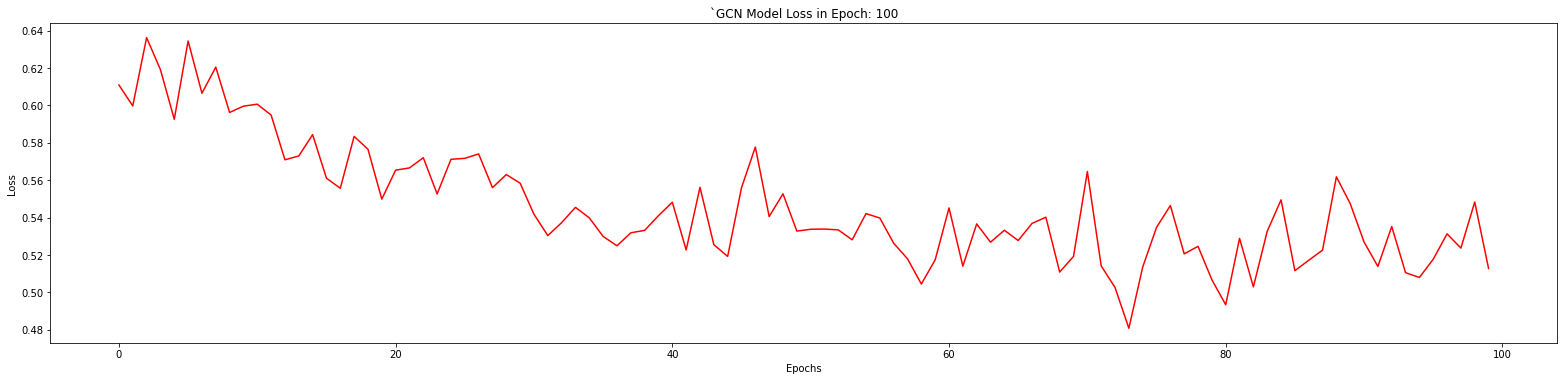

Epoch: 101, Evaluation of GNNs Model Loss: 0.5476
Epoch: 102, Evaluation of GNNs Model Loss: 0.5339
Epoch: 103, Evaluation of GNNs Model Loss: 0.5187
Epoch: 104, Evaluation of GNNs Model Loss: 0.5323
Epoch: 105, Evaluation of GNNs Model Loss: 0.5010
Epoch: 106, Evaluation of GNNs Model Loss: 0.5074
Epoch: 107, Evaluation of GNNs Model Loss: 0.5160
Epoch: 108, Evaluation of GNNs Model Loss: 0.5348
Epoch: 109, Evaluation of GNNs Model Loss: 0.5394
Epoch: 110, Evaluation of GNNs Model Loss: 0.4859
Epoch: 111, Evaluation of GNNs Model Loss: 0.5277
Epoch: 112, Evaluation of GNNs Model Loss: 0.5048
Epoch: 113, Evaluation of GNNs Model Loss: 0.5068
Epoch: 114, Evaluation of GNNs Model Loss: 0.5110
Epoch: 115, Evaluation of GNNs Model Loss: 0.5086
Epoch: 116, Evaluation of GNNs Model Loss: 0.5146
Epoch: 117, Evaluation of GNNs Model Loss: 0.5404
Epoch: 118, Evaluation of GNNs Model Loss: 0.5045
Epoch: 119, Evaluation of GNNs Model Loss: 0.4902
Epoch: 120, Evaluation of GNNs Model Loss: 0.5129


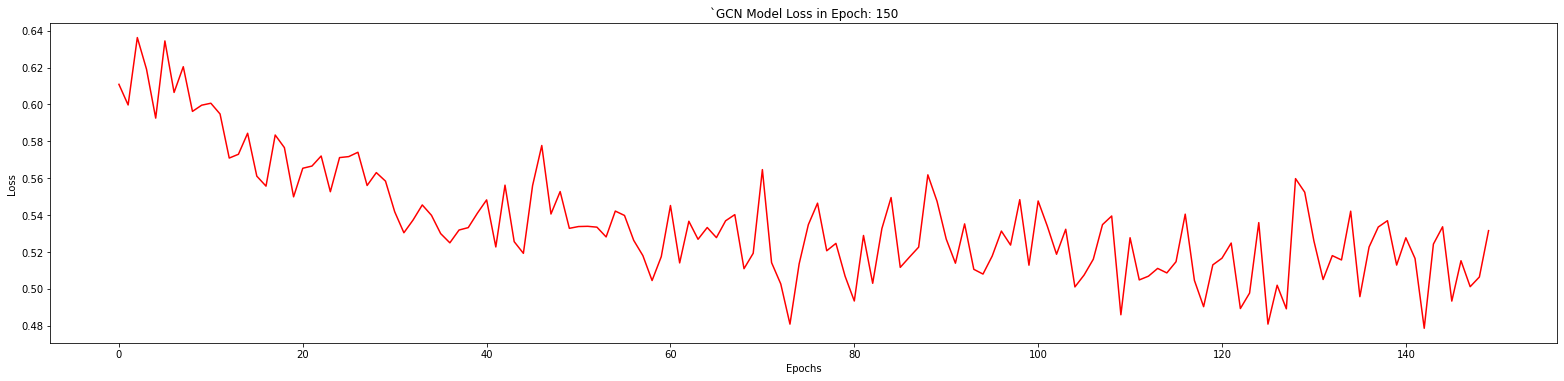

Epoch: 151, Evaluation of GNNs Model Loss: 0.5282
Epoch: 152, Evaluation of GNNs Model Loss: 0.4867
Epoch: 153, Evaluation of GNNs Model Loss: 0.5200
Epoch: 154, Evaluation of GNNs Model Loss: 0.5024
Epoch: 155, Evaluation of GNNs Model Loss: 0.4927
Epoch: 156, Evaluation of GNNs Model Loss: 0.5107
Epoch: 157, Evaluation of GNNs Model Loss: 0.5166
Epoch: 158, Evaluation of GNNs Model Loss: 0.5071
Epoch: 159, Evaluation of GNNs Model Loss: 0.5061
Epoch: 160, Evaluation of GNNs Model Loss: 0.4964
Epoch: 161, Evaluation of GNNs Model Loss: 0.5003
Epoch: 162, Evaluation of GNNs Model Loss: 0.5150
Epoch: 163, Evaluation of GNNs Model Loss: 0.5598
Epoch: 164, Evaluation of GNNs Model Loss: 0.5347
Epoch: 165, Evaluation of GNNs Model Loss: 0.5352
Epoch: 166, Evaluation of GNNs Model Loss: 0.5238
Epoch: 167, Evaluation of GNNs Model Loss: 0.5114
Epoch: 168, Evaluation of GNNs Model Loss: 0.5359
Epoch: 169, Evaluation of GNNs Model Loss: 0.5006
Epoch: 170, Evaluation of GNNs Model Loss: 0.5196


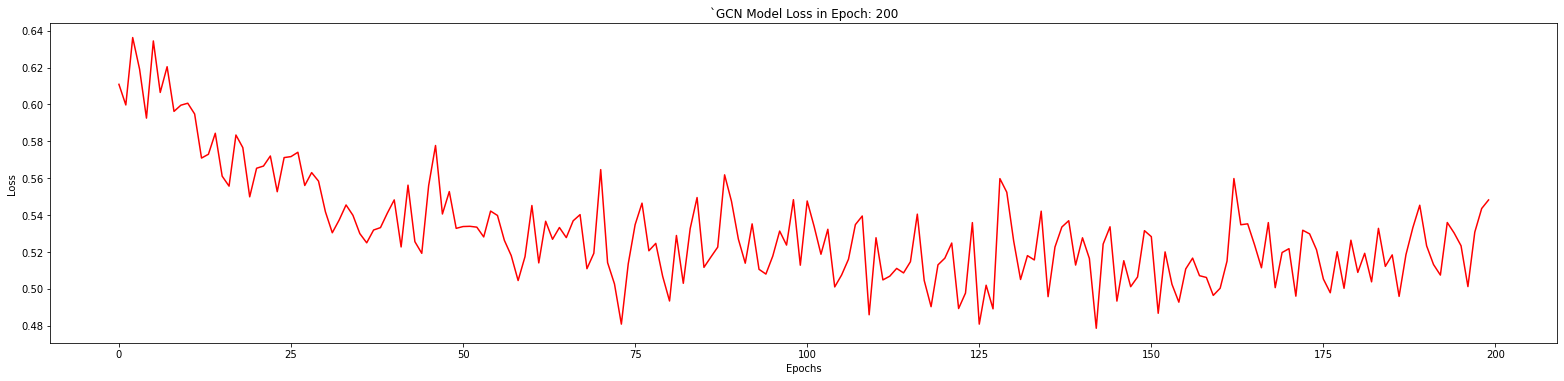

Epoch: 001, Evaluation of GNNs Model Loss: 0.6603
Epoch: 002, Evaluation of GNNs Model Loss: 0.6305
Epoch: 003, Evaluation of GNNs Model Loss: 0.6410
Epoch: 004, Evaluation of GNNs Model Loss: 0.6359
Epoch: 005, Evaluation of GNNs Model Loss: 0.6301
Epoch: 006, Evaluation of GNNs Model Loss: 0.6241
Epoch: 007, Evaluation of GNNs Model Loss: 0.6192
Epoch: 008, Evaluation of GNNs Model Loss: 0.6135
Epoch: 009, Evaluation of GNNs Model Loss: 0.6137
Epoch: 010, Evaluation of GNNs Model Loss: 0.5978
Epoch: 011, Evaluation of GNNs Model Loss: 0.6075
Epoch: 012, Evaluation of GNNs Model Loss: 0.6041
Epoch: 013, Evaluation of GNNs Model Loss: 0.5836
Epoch: 014, Evaluation of GNNs Model Loss: 0.5905
Epoch: 015, Evaluation of GNNs Model Loss: 0.5806
Epoch: 016, Evaluation of GNNs Model Loss: 0.5932
Epoch: 017, Evaluation of GNNs Model Loss: 0.5980
Epoch: 018, Evaluation of GNNs Model Loss: 0.6073
Epoch: 019, Evaluation of GNNs Model Loss: 0.5846
Epoch: 020, Evaluation of GNNs Model Loss: 0.5880


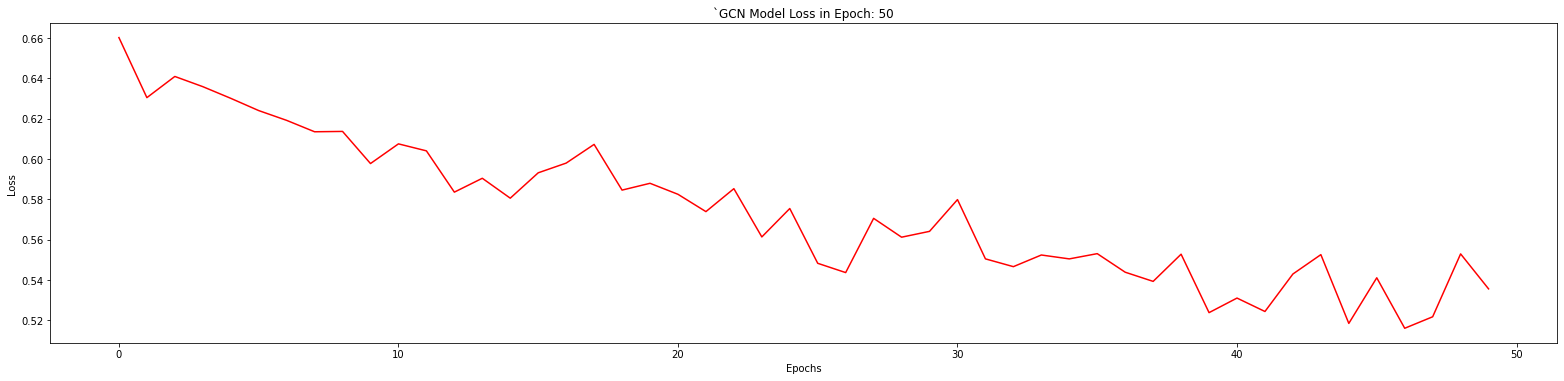

Epoch: 051, Evaluation of GNNs Model Loss: 0.4981
Epoch: 052, Evaluation of GNNs Model Loss: 0.5270
Epoch: 053, Evaluation of GNNs Model Loss: 0.5455
Epoch: 054, Evaluation of GNNs Model Loss: 0.5665
Epoch: 055, Evaluation of GNNs Model Loss: 0.5442
Epoch: 056, Evaluation of GNNs Model Loss: 0.5245
Epoch: 057, Evaluation of GNNs Model Loss: 0.5107
Epoch: 058, Evaluation of GNNs Model Loss: 0.5282
Epoch: 059, Evaluation of GNNs Model Loss: 0.5082
Epoch: 060, Evaluation of GNNs Model Loss: 0.5189
Epoch: 061, Evaluation of GNNs Model Loss: 0.5305
Epoch: 062, Evaluation of GNNs Model Loss: 0.5125
Epoch: 063, Evaluation of GNNs Model Loss: 0.4961
Epoch: 064, Evaluation of GNNs Model Loss: 0.5266
Epoch: 065, Evaluation of GNNs Model Loss: 0.5008
Epoch: 066, Evaluation of GNNs Model Loss: 0.5121
Epoch: 067, Evaluation of GNNs Model Loss: 0.5103
Epoch: 068, Evaluation of GNNs Model Loss: 0.5287
Epoch: 069, Evaluation of GNNs Model Loss: 0.5364
Epoch: 070, Evaluation of GNNs Model Loss: 0.5164


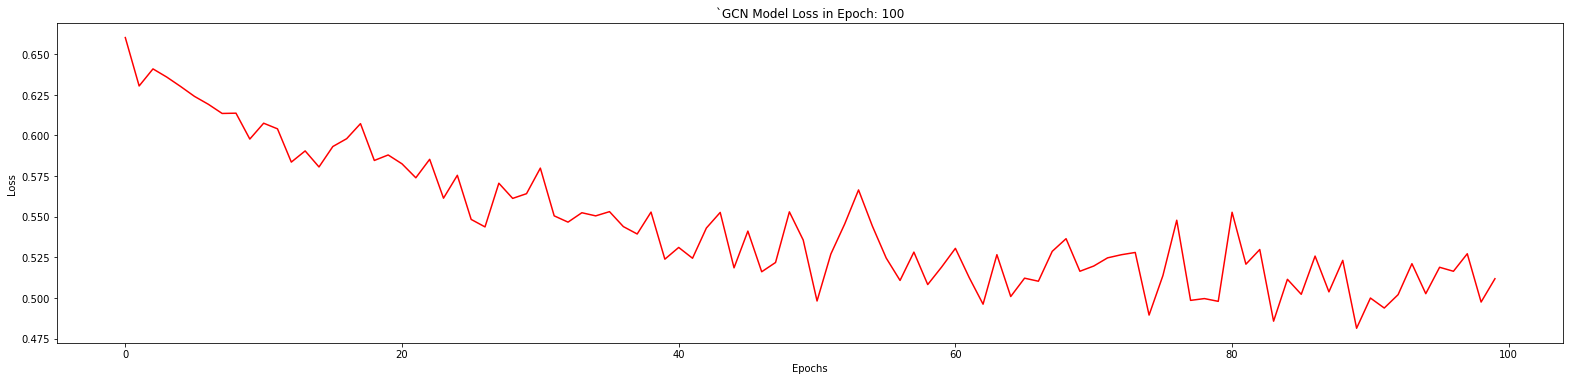

Epoch: 101, Evaluation of GNNs Model Loss: 0.5315
Epoch: 102, Evaluation of GNNs Model Loss: 0.4572
Epoch: 103, Evaluation of GNNs Model Loss: 0.4881
Epoch: 104, Evaluation of GNNs Model Loss: 0.4724
Epoch: 105, Evaluation of GNNs Model Loss: 0.5347
Epoch: 106, Evaluation of GNNs Model Loss: 0.5230
Epoch: 107, Evaluation of GNNs Model Loss: 0.5102
Epoch: 108, Evaluation of GNNs Model Loss: 0.4746
Epoch: 109, Evaluation of GNNs Model Loss: 0.5038
Epoch: 110, Evaluation of GNNs Model Loss: 0.5478
Epoch: 111, Evaluation of GNNs Model Loss: 0.4943
Epoch: 112, Evaluation of GNNs Model Loss: 0.4943
Epoch: 113, Evaluation of GNNs Model Loss: 0.5213
Epoch: 114, Evaluation of GNNs Model Loss: 0.5187
Epoch: 115, Evaluation of GNNs Model Loss: 0.5242
Epoch: 116, Evaluation of GNNs Model Loss: 0.5341
Epoch: 117, Evaluation of GNNs Model Loss: 0.4956
Epoch: 118, Evaluation of GNNs Model Loss: 0.4835
Epoch: 119, Evaluation of GNNs Model Loss: 0.4664
Epoch: 120, Evaluation of GNNs Model Loss: 0.4875


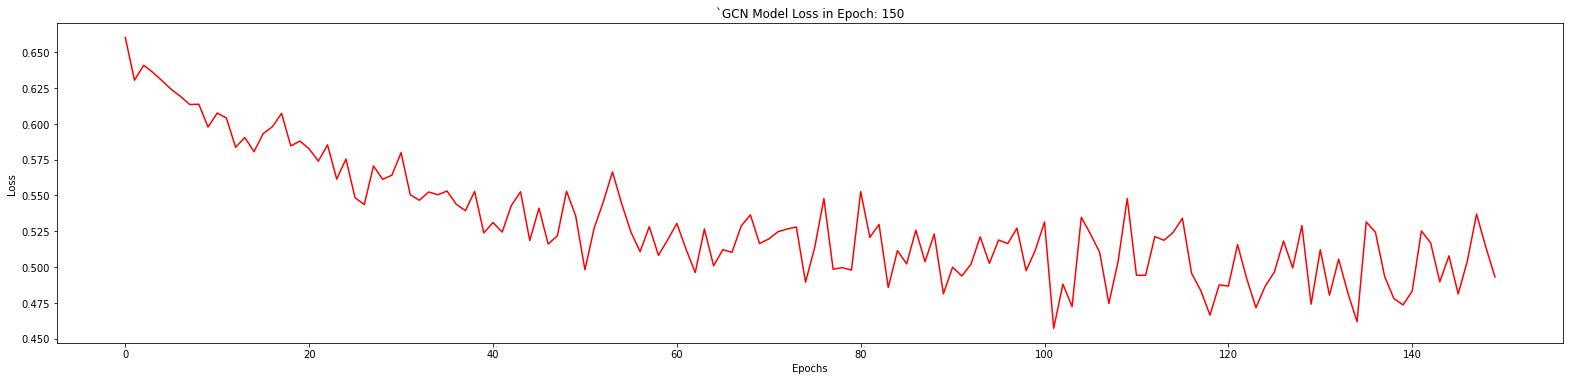

Epoch: 151, Evaluation of GNNs Model Loss: 0.4846
Epoch: 152, Evaluation of GNNs Model Loss: 0.5047
Epoch: 153, Evaluation of GNNs Model Loss: 0.5057
Epoch: 154, Evaluation of GNNs Model Loss: 0.5319
Epoch: 155, Evaluation of GNNs Model Loss: 0.4775
Epoch: 156, Evaluation of GNNs Model Loss: 0.5104
Epoch: 157, Evaluation of GNNs Model Loss: 0.4956
Epoch: 158, Evaluation of GNNs Model Loss: 0.4630
Epoch: 159, Evaluation of GNNs Model Loss: 0.5268
Epoch: 160, Evaluation of GNNs Model Loss: 0.5542
Epoch: 161, Evaluation of GNNs Model Loss: 0.5531
Epoch: 162, Evaluation of GNNs Model Loss: 0.4543
Epoch: 163, Evaluation of GNNs Model Loss: 0.5279
Epoch: 164, Evaluation of GNNs Model Loss: 0.5500
Epoch: 165, Evaluation of GNNs Model Loss: 0.4826
Epoch: 166, Evaluation of GNNs Model Loss: 0.5012
Epoch: 167, Evaluation of GNNs Model Loss: 0.4774
Epoch: 168, Evaluation of GNNs Model Loss: 0.5090
Epoch: 169, Evaluation of GNNs Model Loss: 0.4978
Epoch: 170, Evaluation of GNNs Model Loss: 0.4837


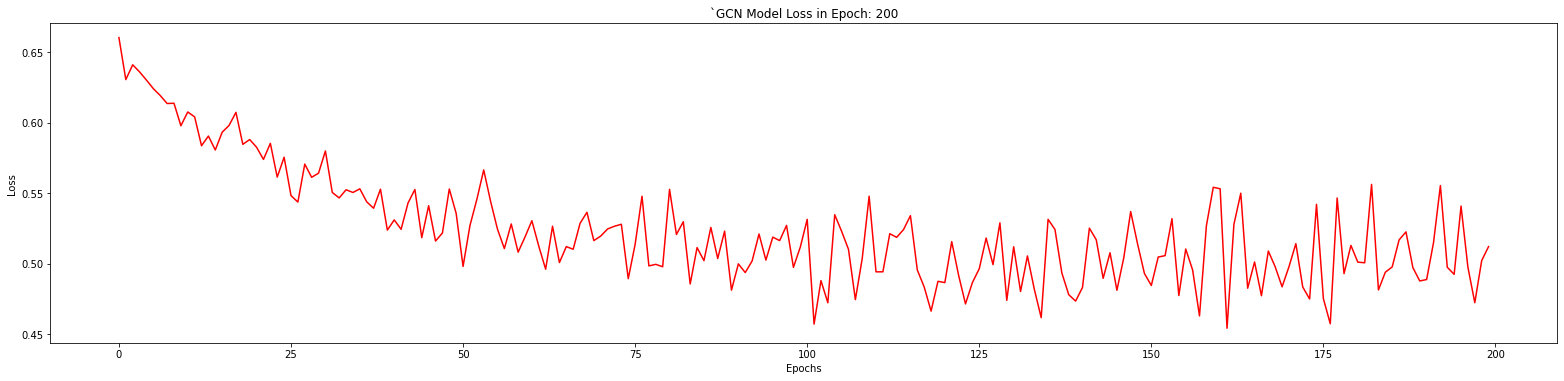

Epoch: 001, Evaluation of GNNs Model Loss: 0.6862
Epoch: 002, Evaluation of GNNs Model Loss: 0.6785
Epoch: 003, Evaluation of GNNs Model Loss: 0.6624
Epoch: 004, Evaluation of GNNs Model Loss: 0.6528
Epoch: 005, Evaluation of GNNs Model Loss: 0.6584
Epoch: 006, Evaluation of GNNs Model Loss: 0.6402
Epoch: 007, Evaluation of GNNs Model Loss: 0.6521
Epoch: 008, Evaluation of GNNs Model Loss: 0.6477
Epoch: 009, Evaluation of GNNs Model Loss: 0.6517
Epoch: 010, Evaluation of GNNs Model Loss: 0.6598
Epoch: 011, Evaluation of GNNs Model Loss: 0.6505
Epoch: 012, Evaluation of GNNs Model Loss: 0.6550
Epoch: 013, Evaluation of GNNs Model Loss: 0.6321
Epoch: 014, Evaluation of GNNs Model Loss: 0.6357
Epoch: 015, Evaluation of GNNs Model Loss: 0.6314
Epoch: 016, Evaluation of GNNs Model Loss: 0.6382
Epoch: 017, Evaluation of GNNs Model Loss: 0.6446
Epoch: 018, Evaluation of GNNs Model Loss: 0.6342
Epoch: 019, Evaluation of GNNs Model Loss: 0.6284
Epoch: 020, Evaluation of GNNs Model Loss: 0.6382


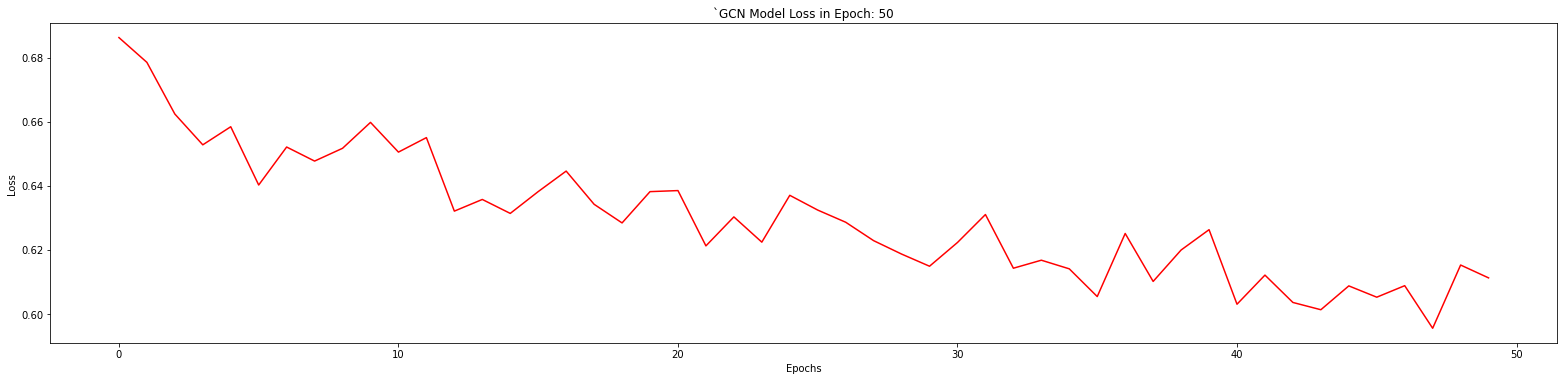

Epoch: 051, Evaluation of GNNs Model Loss: 0.6109
Epoch: 052, Evaluation of GNNs Model Loss: 0.5934
Epoch: 053, Evaluation of GNNs Model Loss: 0.6029
Epoch: 054, Evaluation of GNNs Model Loss: 0.5996
Epoch: 055, Evaluation of GNNs Model Loss: 0.5861
Epoch: 056, Evaluation of GNNs Model Loss: 0.5650
Epoch: 057, Evaluation of GNNs Model Loss: 0.5754
Epoch: 058, Evaluation of GNNs Model Loss: 0.5796
Epoch: 059, Evaluation of GNNs Model Loss: 0.6116
Epoch: 060, Evaluation of GNNs Model Loss: 0.5648
Epoch: 061, Evaluation of GNNs Model Loss: 0.5800
Epoch: 062, Evaluation of GNNs Model Loss: 0.5933
Epoch: 063, Evaluation of GNNs Model Loss: 0.5678
Epoch: 064, Evaluation of GNNs Model Loss: 0.5593
Epoch: 065, Evaluation of GNNs Model Loss: 0.5922
Epoch: 066, Evaluation of GNNs Model Loss: 0.5601
Epoch: 067, Evaluation of GNNs Model Loss: 0.6028
Epoch: 068, Evaluation of GNNs Model Loss: 0.5819
Epoch: 069, Evaluation of GNNs Model Loss: 0.5943
Epoch: 070, Evaluation of GNNs Model Loss: 0.5562


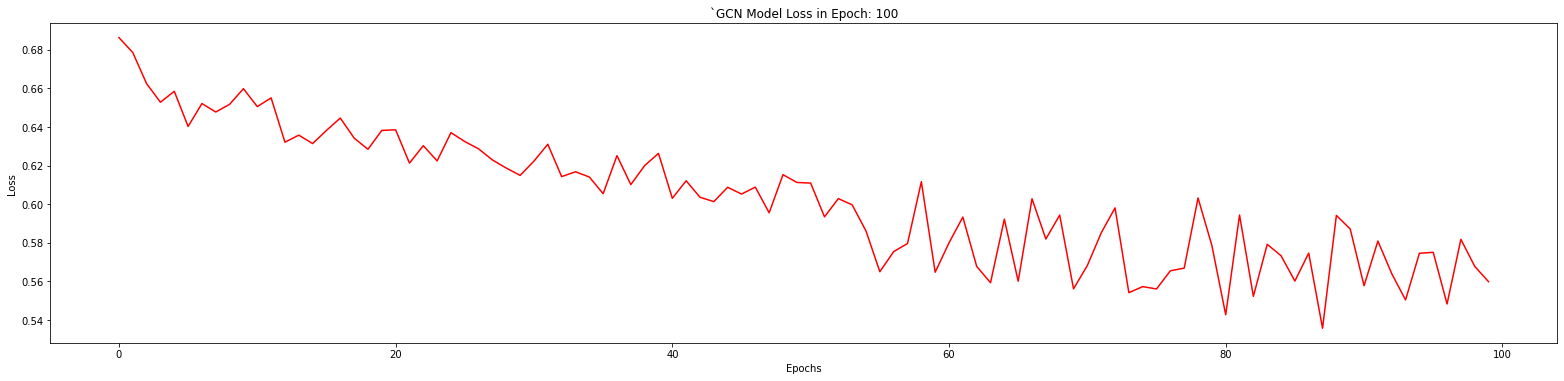

Epoch: 101, Evaluation of GNNs Model Loss: 0.5389
Epoch: 102, Evaluation of GNNs Model Loss: 0.5754
Epoch: 103, Evaluation of GNNs Model Loss: 0.5744
Epoch: 104, Evaluation of GNNs Model Loss: 0.5375
Epoch: 105, Evaluation of GNNs Model Loss: 0.5311
Epoch: 106, Evaluation of GNNs Model Loss: 0.5381
Epoch: 107, Evaluation of GNNs Model Loss: 0.5473
Epoch: 108, Evaluation of GNNs Model Loss: 0.5481
Epoch: 109, Evaluation of GNNs Model Loss: 0.5855
Epoch: 110, Evaluation of GNNs Model Loss: 0.5485
Epoch: 111, Evaluation of GNNs Model Loss: 0.5893
Epoch: 112, Evaluation of GNNs Model Loss: 0.5446
Epoch: 113, Evaluation of GNNs Model Loss: 0.6129
Epoch: 114, Evaluation of GNNs Model Loss: 0.5818
Epoch: 115, Evaluation of GNNs Model Loss: 0.5366
Epoch: 116, Evaluation of GNNs Model Loss: 0.5518
Epoch: 117, Evaluation of GNNs Model Loss: 0.5698
Epoch: 118, Evaluation of GNNs Model Loss: 0.5473
Epoch: 119, Evaluation of GNNs Model Loss: 0.5620
Epoch: 120, Evaluation of GNNs Model Loss: 0.5742


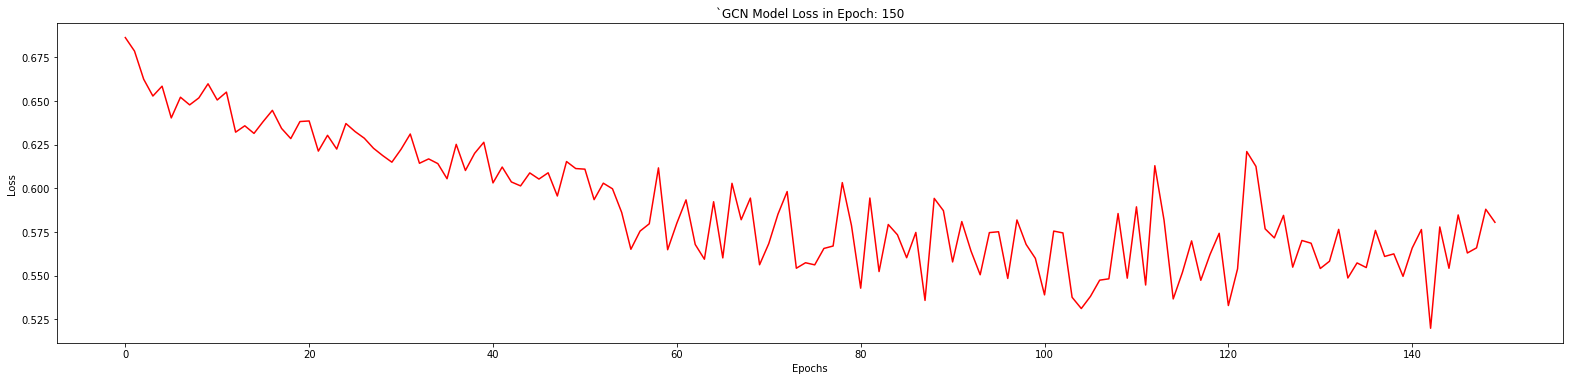

Epoch: 151, Evaluation of GNNs Model Loss: 0.5890
Epoch: 152, Evaluation of GNNs Model Loss: 0.5513
Epoch: 153, Evaluation of GNNs Model Loss: 0.5518
Epoch: 154, Evaluation of GNNs Model Loss: 0.5546
Epoch: 155, Evaluation of GNNs Model Loss: 0.5952
Epoch: 156, Evaluation of GNNs Model Loss: 0.5733
Epoch: 157, Evaluation of GNNs Model Loss: 0.5671
Epoch: 158, Evaluation of GNNs Model Loss: 0.5807
Epoch: 159, Evaluation of GNNs Model Loss: 0.5608
Epoch: 160, Evaluation of GNNs Model Loss: 0.5917
Epoch: 161, Evaluation of GNNs Model Loss: 0.5717
Epoch: 162, Evaluation of GNNs Model Loss: 0.5648
Epoch: 163, Evaluation of GNNs Model Loss: 0.5552
Epoch: 164, Evaluation of GNNs Model Loss: 0.5520
Epoch: 165, Evaluation of GNNs Model Loss: 0.5325
Epoch: 166, Evaluation of GNNs Model Loss: 0.5849
Epoch: 167, Evaluation of GNNs Model Loss: 0.5737
Epoch: 168, Evaluation of GNNs Model Loss: 0.5547
Epoch: 169, Evaluation of GNNs Model Loss: 0.5264
Epoch: 170, Evaluation of GNNs Model Loss: 0.5706


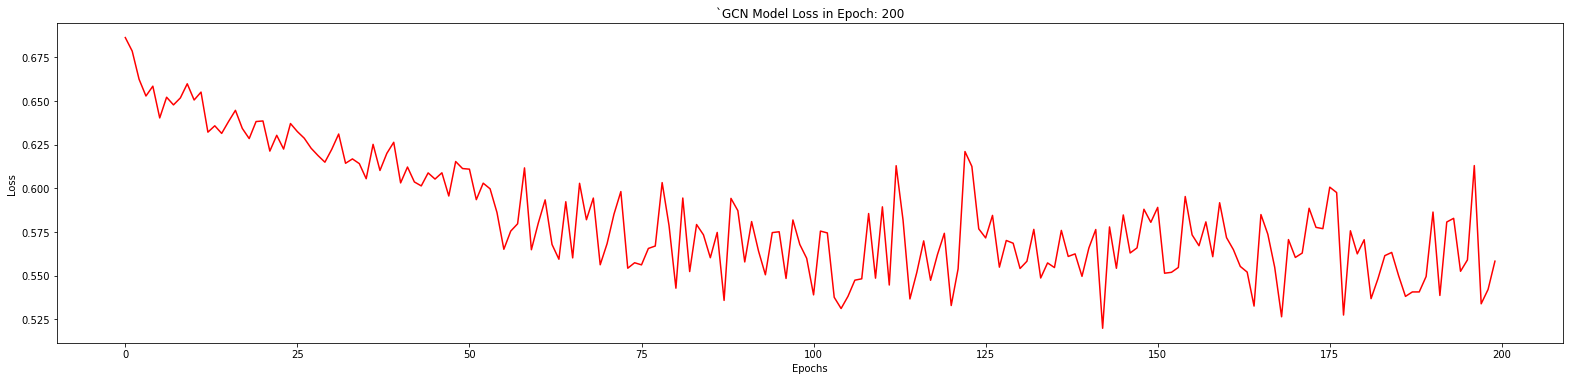

iTeration: 001 is Passed!
{'Batch_count_by_16': 3, 'Bias': False, 'Dataset_name': 1, 'DropOut_Rate': 0.3304834978715692, 'EPOCHS': 100, 'Loss_Function': 1, 'Model_name': 1, 'Weight_Initializer': 3, 'load_index': 0, 'lr': 0.00837842315296335, 'num_folds': 2}
Epoch: 001, Evaluation of GNNs Model Loss: 0.6887
Epoch: 002, Evaluation of GNNs Model Loss: 0.6849
Epoch: 003, Evaluation of GNNs Model Loss: 0.6802
Epoch: 004, Evaluation of GNNs Model Loss: 0.6746
Epoch: 005, Evaluation of GNNs Model Loss: 0.6705
Epoch: 006, Evaluation of GNNs Model Loss: 0.6614
Epoch: 007, Evaluation of GNNs Model Loss: 0.6564
Epoch: 008, Evaluation of GNNs Model Loss: 0.6497
Epoch: 009, Evaluation of GNNs Model Loss: 0.6423
Epoch: 010, Evaluation of GNNs Model Loss: 0.6336
Epoch: 011, Evaluation of GNNs Model Loss: 0.6208
Epoch: 012, Evaluation of GNNs Model Loss: 0.6135
Epoch: 013, Evaluation of GNNs Model Loss: 0.6117
Epoch: 014, Evaluation of GNNs Model Loss: 0.6162
Epoch: 015, Evaluation of GNNs Model Loss:

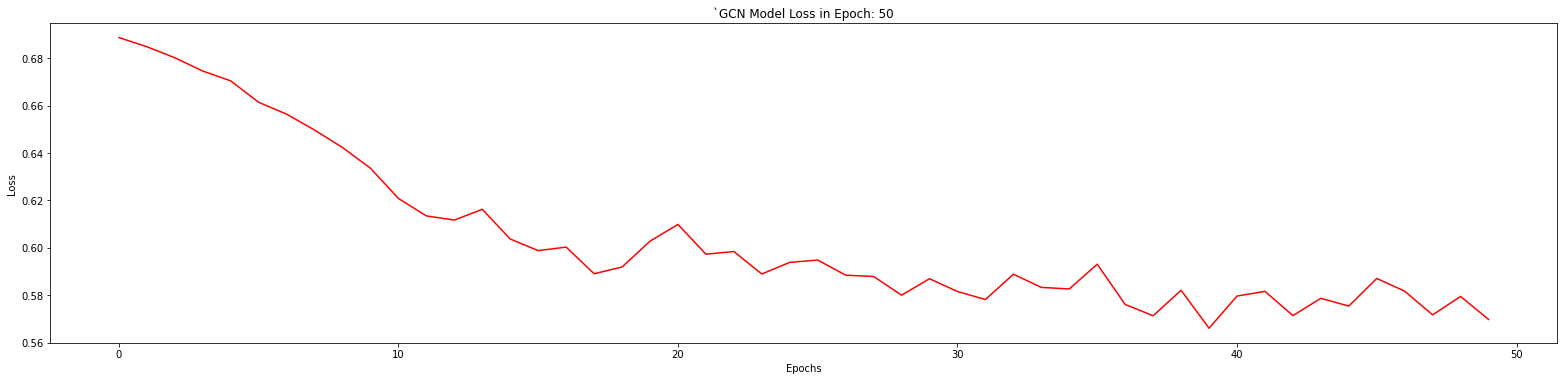

Epoch: 051, Evaluation of GNNs Model Loss: 0.5661
Epoch: 052, Evaluation of GNNs Model Loss: 0.5687
Epoch: 053, Evaluation of GNNs Model Loss: 0.5783
Epoch: 054, Evaluation of GNNs Model Loss: 0.5665
Epoch: 055, Evaluation of GNNs Model Loss: 0.5833
Epoch: 056, Evaluation of GNNs Model Loss: 0.5705
Epoch: 057, Evaluation of GNNs Model Loss: 0.5727
Epoch: 058, Evaluation of GNNs Model Loss: 0.5682
Epoch: 059, Evaluation of GNNs Model Loss: 0.5735
Epoch: 060, Evaluation of GNNs Model Loss: 0.5734
Epoch: 061, Evaluation of GNNs Model Loss: 0.5499
Epoch: 062, Evaluation of GNNs Model Loss: 0.5560
Epoch: 063, Evaluation of GNNs Model Loss: 0.5639
Epoch: 064, Evaluation of GNNs Model Loss: 0.5802
Epoch: 065, Evaluation of GNNs Model Loss: 0.5539
Epoch: 066, Evaluation of GNNs Model Loss: 0.5699
Epoch: 067, Evaluation of GNNs Model Loss: 0.5683
Epoch: 068, Evaluation of GNNs Model Loss: 0.5513
Epoch: 069, Evaluation of GNNs Model Loss: 0.5570
Epoch: 070, Evaluation of GNNs Model Loss: 0.5604


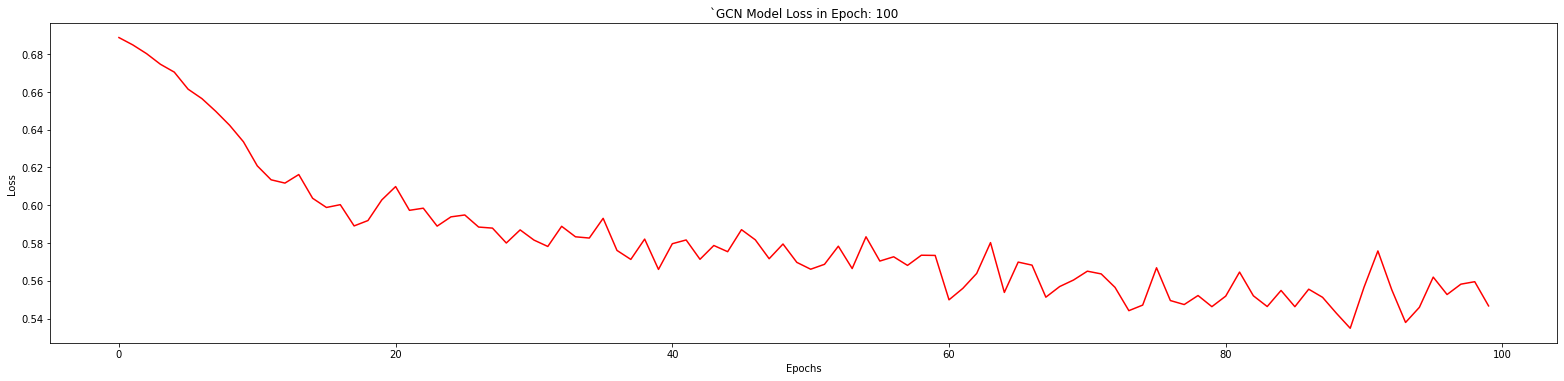

Epoch: 001, Evaluation of GNNs Model Loss: 0.6937
Epoch: 002, Evaluation of GNNs Model Loss: 0.6927
Epoch: 003, Evaluation of GNNs Model Loss: 0.6918
Epoch: 004, Evaluation of GNNs Model Loss: 0.6909
Epoch: 005, Evaluation of GNNs Model Loss: 0.6895
Epoch: 006, Evaluation of GNNs Model Loss: 0.6886
Epoch: 007, Evaluation of GNNs Model Loss: 0.6866
Epoch: 008, Evaluation of GNNs Model Loss: 0.6838
Epoch: 009, Evaluation of GNNs Model Loss: 0.6815
Epoch: 010, Evaluation of GNNs Model Loss: 0.6768
Epoch: 011, Evaluation of GNNs Model Loss: 0.6718
Epoch: 012, Evaluation of GNNs Model Loss: 0.6694
Epoch: 013, Evaluation of GNNs Model Loss: 0.6644
Epoch: 014, Evaluation of GNNs Model Loss: 0.6607
Epoch: 015, Evaluation of GNNs Model Loss: 0.6543
Epoch: 016, Evaluation of GNNs Model Loss: 0.6542
Epoch: 017, Evaluation of GNNs Model Loss: 0.6521
Epoch: 018, Evaluation of GNNs Model Loss: 0.6466
Epoch: 019, Evaluation of GNNs Model Loss: 0.6435
Epoch: 020, Evaluation of GNNs Model Loss: 0.6473


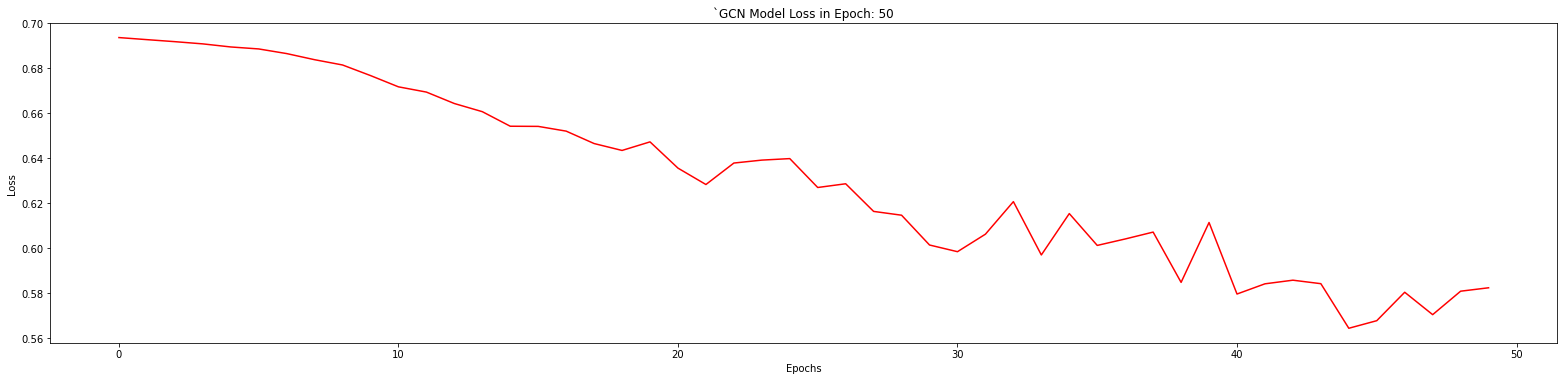

Epoch: 051, Evaluation of GNNs Model Loss: 0.5595
Epoch: 052, Evaluation of GNNs Model Loss: 0.5721
Epoch: 053, Evaluation of GNNs Model Loss: 0.5562
Epoch: 054, Evaluation of GNNs Model Loss: 0.5694
Epoch: 055, Evaluation of GNNs Model Loss: 0.5523
Epoch: 056, Evaluation of GNNs Model Loss: 0.5846
Epoch: 057, Evaluation of GNNs Model Loss: 0.5745
Epoch: 058, Evaluation of GNNs Model Loss: 0.5445
Epoch: 059, Evaluation of GNNs Model Loss: 0.5698
Epoch: 060, Evaluation of GNNs Model Loss: 0.5550
Epoch: 061, Evaluation of GNNs Model Loss: 0.5409
Epoch: 062, Evaluation of GNNs Model Loss: 0.5439
Epoch: 063, Evaluation of GNNs Model Loss: 0.5457
Epoch: 064, Evaluation of GNNs Model Loss: 0.5193
Epoch: 065, Evaluation of GNNs Model Loss: 0.5614
Epoch: 066, Evaluation of GNNs Model Loss: 0.5353
Epoch: 067, Evaluation of GNNs Model Loss: 0.5490
Epoch: 068, Evaluation of GNNs Model Loss: 0.5659
Epoch: 069, Evaluation of GNNs Model Loss: 0.5526
Epoch: 070, Evaluation of GNNs Model Loss: 0.5412


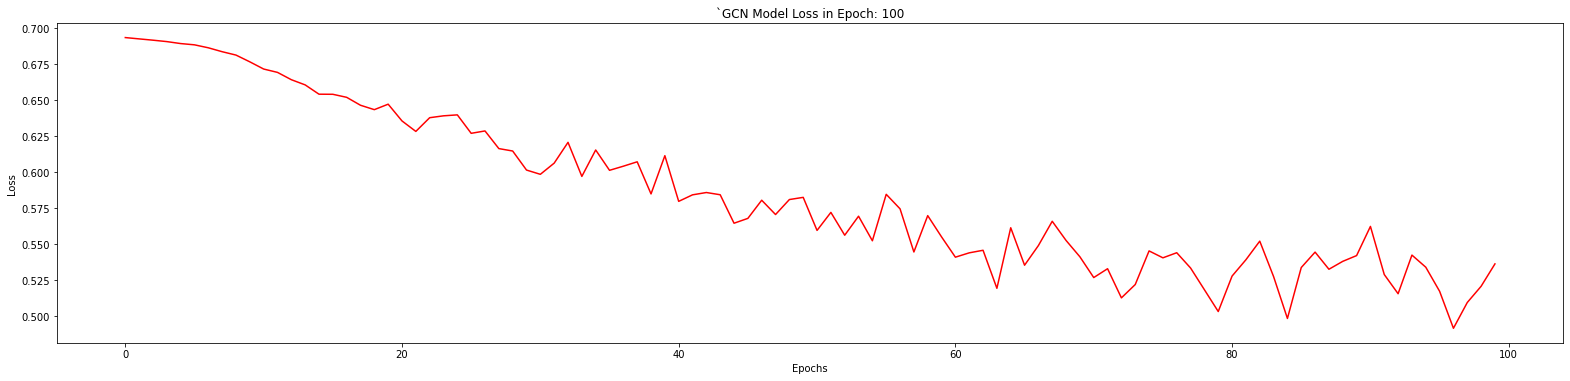

iTeration: 002 is Passed!
{'Batch_count_by_16': 1, 'Bias': False, 'Dataset_name': 1, 'DropOut_Rate': 0.3931150997014161, 'EPOCHS': 100, 'Loss_Function': 3, 'Model_name': 1, 'Weight_Initializer': 2, 'load_index': 0, 'lr': 0.0013058889057703971, 'num_folds': 3}


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 001, Evaluation of GNNs Model Loss: 0.7941
Epoch: 002, Evaluation of GNNs Model Loss: 0.8110
Epoch: 003, Evaluation of GNNs Model Loss: 0.7849
Epoch: 004, Evaluation of GNNs Model Loss: 0.7802
Epoch: 005, Evaluation of GNNs Model Loss: 0.7174
Epoch: 006, Evaluation of GNNs Model Loss: 0.7141
Epoch: 007, Evaluation of GNNs Model Loss: 0.6942
Epoch: 008, Evaluation of GNNs Model Loss: 0.6617
Epoch: 009, Evaluation of GNNs Model Loss: 0.6792
Epoch: 010, Evaluation of GNNs Model Loss: 0.6229
Epoch: 011, Evaluation of GNNs Model Loss: 0.6344
Epoch: 012, Evaluation of GNNs Model Loss: 0.5909
Epoch: 013, Evaluation of GNNs Model Loss: 0.5662
Epoch: 014, Evaluation of GNNs Model Loss: 0.5356
Epoch: 015, Evaluation of GNNs Model Loss: 0.5199
Epoch: 016, Evaluation of GNNs Model Loss: 0.5007
Epoch: 017, Evaluation of GNNs Model Loss: 0.4654
Epoch: 018, Evaluation of GNNs Model Loss: 0.4571
Epoch: 019, Evaluation of GNNs Model Loss: 0.4604
Epoch: 020, Evaluation of GNNs Model Loss: 0.4155


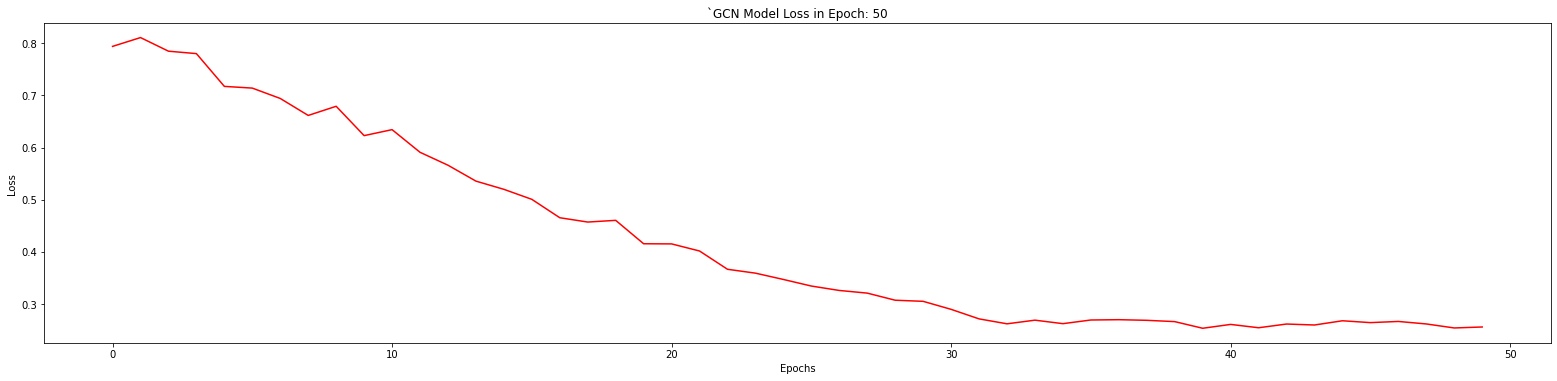

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 051, Evaluation of GNNs Model Loss: 0.2524
Epoch: 052, Evaluation of GNNs Model Loss: 0.2484
Epoch: 053, Evaluation of GNNs Model Loss: 0.2547
Epoch: 054, Evaluation of GNNs Model Loss: 0.2689
Epoch: 055, Evaluation of GNNs Model Loss: 0.2548
Epoch: 056, Evaluation of GNNs Model Loss: 0.2592
Epoch: 057, Evaluation of GNNs Model Loss: 0.2585
Epoch: 058, Evaluation of GNNs Model Loss: 0.2535
Epoch: 059, Evaluation of GNNs Model Loss: 0.2581
Epoch: 060, Evaluation of GNNs Model Loss: 0.2570
Epoch: 061, Evaluation of GNNs Model Loss: 0.2562
Epoch: 062, Evaluation of GNNs Model Loss: 0.2592
Epoch: 063, Evaluation of GNNs Model Loss: 0.2533
Epoch: 064, Evaluation of GNNs Model Loss: 0.2592
Epoch: 065, Evaluation of GNNs Model Loss: 0.2503
Epoch: 066, Evaluation of GNNs Model Loss: 0.2526
Epoch: 067, Evaluation of GNNs Model Loss: 0.2515
Epoch: 068, Evaluation of GNNs Model Loss: 0.2502
Epoch: 069, Evaluation of GNNs Model Loss: 0.2535
Epoch: 070, Evaluation of GNNs Model Loss: 0.2543


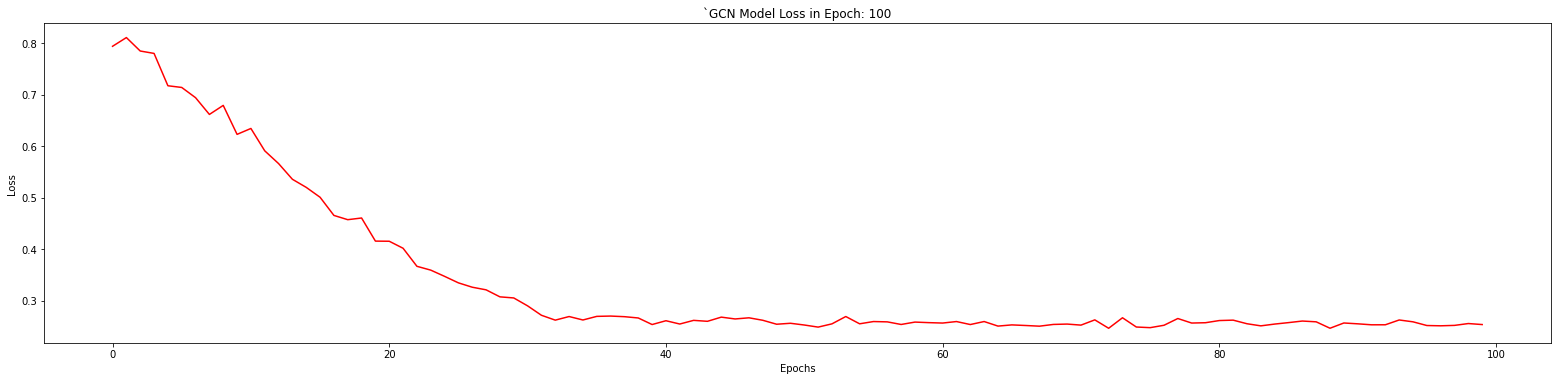

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 001, Evaluation of GNNs Model Loss: 1.5685
Epoch: 002, Evaluation of GNNs Model Loss: 1.4623
Epoch: 003, Evaluation of GNNs Model Loss: 1.5381
Epoch: 004, Evaluation of GNNs Model Loss: 1.3936
Epoch: 005, Evaluation of GNNs Model Loss: 1.3345
Epoch: 006, Evaluation of GNNs Model Loss: 1.2404
Epoch: 007, Evaluation of GNNs Model Loss: 1.1085
Epoch: 008, Evaluation of GNNs Model Loss: 1.1327
Epoch: 009, Evaluation of GNNs Model Loss: 1.0318
Epoch: 010, Evaluation of GNNs Model Loss: 0.9577
Epoch: 011, Evaluation of GNNs Model Loss: 0.8964
Epoch: 012, Evaluation of GNNs Model Loss: 0.8822
Epoch: 013, Evaluation of GNNs Model Loss: 0.8735
Epoch: 014, Evaluation of GNNs Model Loss: 0.7645
Epoch: 015, Evaluation of GNNs Model Loss: 0.7127
Epoch: 016, Evaluation of GNNs Model Loss: 0.7040
Epoch: 017, Evaluation of GNNs Model Loss: 0.6942
Epoch: 018, Evaluation of GNNs Model Loss: 0.6031
Epoch: 019, Evaluation of GNNs Model Loss: 0.5851
Epoch: 020, Evaluation of GNNs Model Loss: 0.5379


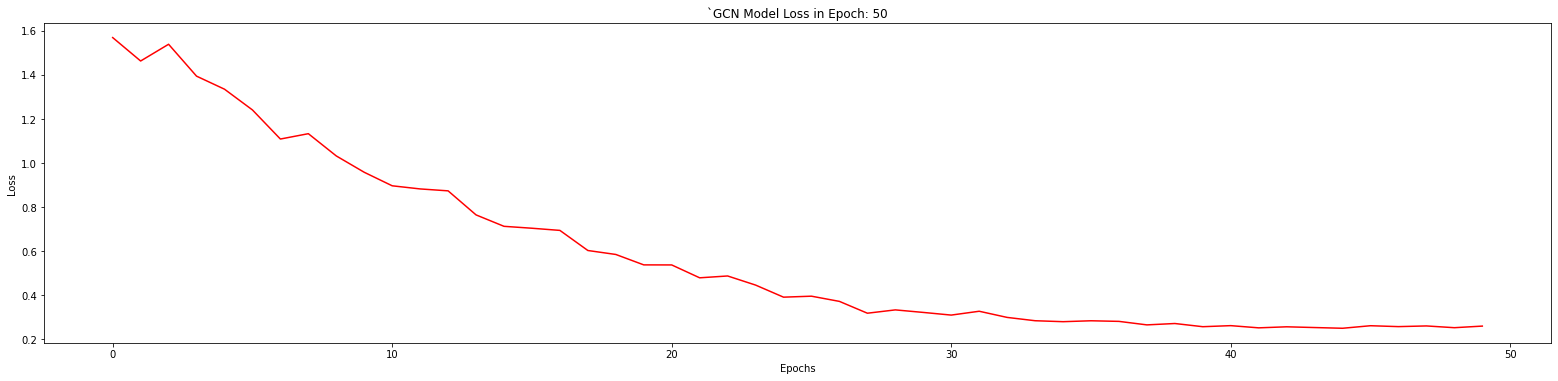

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 051, Evaluation of GNNs Model Loss: 0.2673
Epoch: 052, Evaluation of GNNs Model Loss: 0.2644
Epoch: 053, Evaluation of GNNs Model Loss: 0.2633
Epoch: 054, Evaluation of GNNs Model Loss: 0.2444
Epoch: 055, Evaluation of GNNs Model Loss: 0.2625
Epoch: 056, Evaluation of GNNs Model Loss: 0.2622
Epoch: 057, Evaluation of GNNs Model Loss: 0.2662
Epoch: 058, Evaluation of GNNs Model Loss: 0.2673
Epoch: 059, Evaluation of GNNs Model Loss: 0.2545
Epoch: 060, Evaluation of GNNs Model Loss: 0.2504
Epoch: 061, Evaluation of GNNs Model Loss: 0.2568
Epoch: 062, Evaluation of GNNs Model Loss: 0.2493
Epoch: 063, Evaluation of GNNs Model Loss: 0.2711
Epoch: 064, Evaluation of GNNs Model Loss: 0.2569
Epoch: 065, Evaluation of GNNs Model Loss: 0.2711
Epoch: 066, Evaluation of GNNs Model Loss: 0.2534
Epoch: 067, Evaluation of GNNs Model Loss: 0.2503
Epoch: 068, Evaluation of GNNs Model Loss: 0.2512
Epoch: 069, Evaluation of GNNs Model Loss: 0.2730
Epoch: 070, Evaluation of GNNs Model Loss: 0.2480


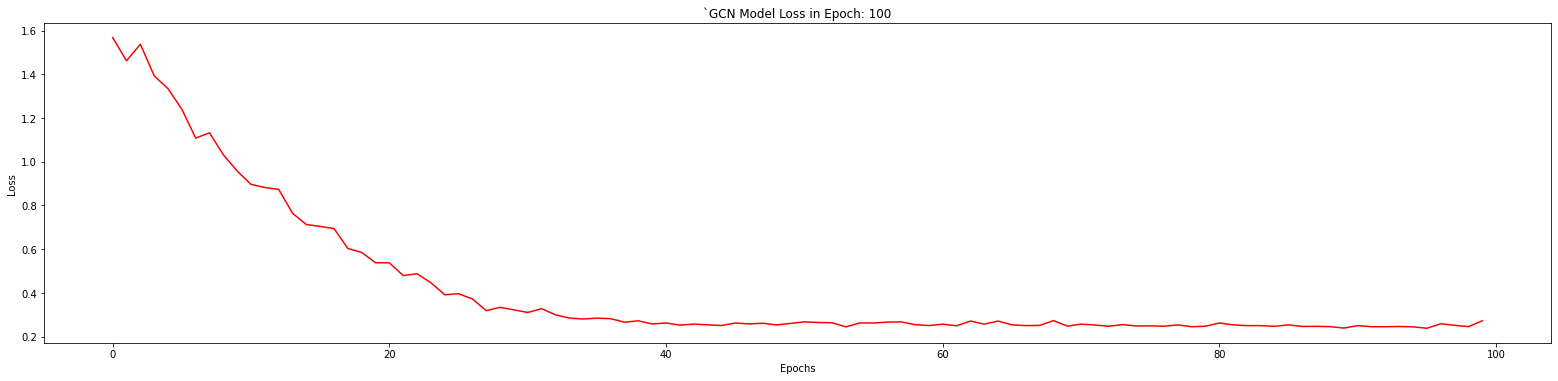

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 001, Evaluation of GNNs Model Loss: 0.3207
Epoch: 002, Evaluation of GNNs Model Loss: 0.3081
Epoch: 003, Evaluation of GNNs Model Loss: 0.3082
Epoch: 004, Evaluation of GNNs Model Loss: 0.2870
Epoch: 005, Evaluation of GNNs Model Loss: 0.2904
Epoch: 006, Evaluation of GNNs Model Loss: 0.3125
Epoch: 007, Evaluation of GNNs Model Loss: 0.2879
Epoch: 008, Evaluation of GNNs Model Loss: 0.2796
Epoch: 009, Evaluation of GNNs Model Loss: 0.2936
Epoch: 010, Evaluation of GNNs Model Loss: 0.3084
Epoch: 011, Evaluation of GNNs Model Loss: 0.2895
Epoch: 012, Evaluation of GNNs Model Loss: 0.2895
Epoch: 013, Evaluation of GNNs Model Loss: 0.2711
Epoch: 014, Evaluation of GNNs Model Loss: 0.2905
Epoch: 015, Evaluation of GNNs Model Loss: 0.2772
Epoch: 016, Evaluation of GNNs Model Loss: 0.2794
Epoch: 017, Evaluation of GNNs Model Loss: 0.2759
Epoch: 018, Evaluation of GNNs Model Loss: 0.3159
Epoch: 019, Evaluation of GNNs Model Loss: 0.2680
Epoch: 020, Evaluation of GNNs Model Loss: 0.2987


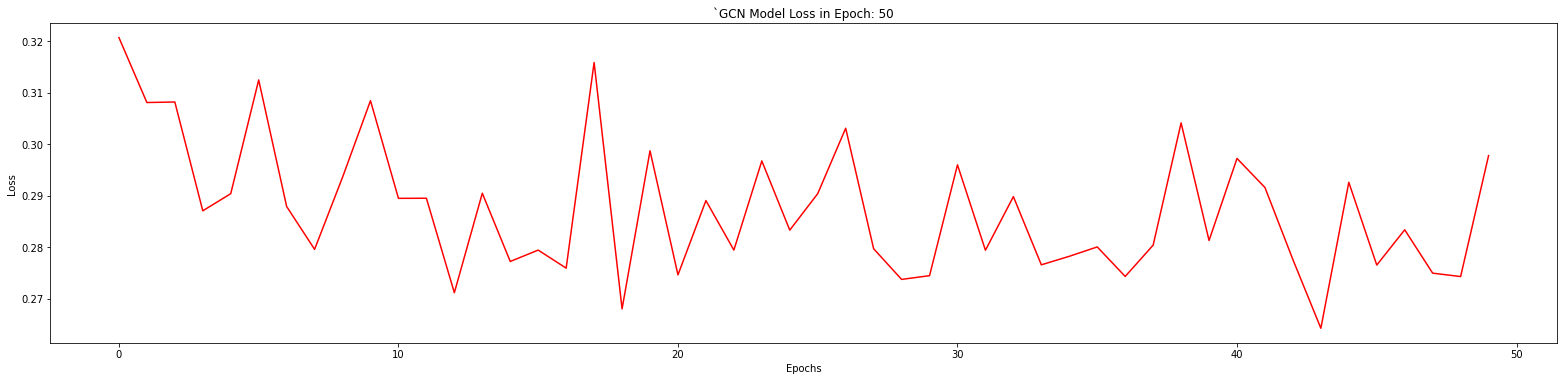

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 051, Evaluation of GNNs Model Loss: 0.2812
Epoch: 052, Evaluation of GNNs Model Loss: 0.2703
Epoch: 053, Evaluation of GNNs Model Loss: 0.2769
Epoch: 054, Evaluation of GNNs Model Loss: 0.2651
Epoch: 055, Evaluation of GNNs Model Loss: 0.2714
Epoch: 056, Evaluation of GNNs Model Loss: 0.2768
Epoch: 057, Evaluation of GNNs Model Loss: 0.2798
Epoch: 058, Evaluation of GNNs Model Loss: 0.2626
Epoch: 059, Evaluation of GNNs Model Loss: 0.2736
Epoch: 060, Evaluation of GNNs Model Loss: 0.2658
Epoch: 061, Evaluation of GNNs Model Loss: 0.2852
Epoch: 062, Evaluation of GNNs Model Loss: 0.2699
Epoch: 063, Evaluation of GNNs Model Loss: 0.2875
Epoch: 064, Evaluation of GNNs Model Loss: 0.2816
Epoch: 065, Evaluation of GNNs Model Loss: 0.2614
Epoch: 066, Evaluation of GNNs Model Loss: 0.2676
Epoch: 067, Evaluation of GNNs Model Loss: 0.2741
Epoch: 068, Evaluation of GNNs Model Loss: 0.2733
Epoch: 069, Evaluation of GNNs Model Loss: 0.2702
Epoch: 070, Evaluation of GNNs Model Loss: 0.2711


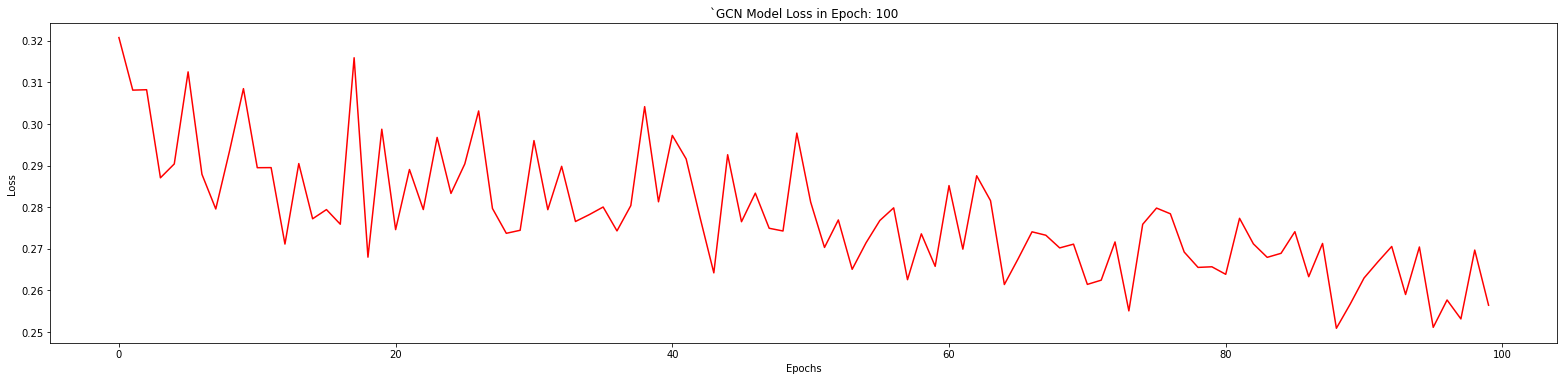

iTeration: 003 is Passed!
{'Batch_count_by_16': 2, 'Bias': True, 'Dataset_name': 1, 'DropOut_Rate': 0.34471963208919404, 'EPOCHS': 200, 'Loss_Function': 3, 'Model_name': 1, 'Weight_Initializer': 3, 'load_index': 0, 'lr': 0.006346836973247765, 'num_folds': 2}
done
done


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 001, Evaluation of GNNs Model Loss: 0.6829
Epoch: 002, Evaluation of GNNs Model Loss: 0.6531
Epoch: 003, Evaluation of GNNs Model Loss: 0.6235
Epoch: 004, Evaluation of GNNs Model Loss: 0.5929
Epoch: 005, Evaluation of GNNs Model Loss: 0.5583
Epoch: 006, Evaluation of GNNs Model Loss: 0.5193
Epoch: 007, Evaluation of GNNs Model Loss: 0.4818
Epoch: 008, Evaluation of GNNs Model Loss: 0.4348
Epoch: 009, Evaluation of GNNs Model Loss: 0.3915
Epoch: 010, Evaluation of GNNs Model Loss: 0.3496
Epoch: 011, Evaluation of GNNs Model Loss: 0.3049
Epoch: 012, Evaluation of GNNs Model Loss: 0.2713
Epoch: 013, Evaluation of GNNs Model Loss: 0.2465
Epoch: 014, Evaluation of GNNs Model Loss: 0.2340
Epoch: 015, Evaluation of GNNs Model Loss: 0.2227
Epoch: 016, Evaluation of GNNs Model Loss: 0.2252
Epoch: 017, Evaluation of GNNs Model Loss: 0.2319
Epoch: 018, Evaluation of GNNs Model Loss: 0.2308
Epoch: 019, Evaluation of GNNs Model Loss: 0.2335
Epoch: 020, Evaluation of GNNs Model Loss: 0.2320


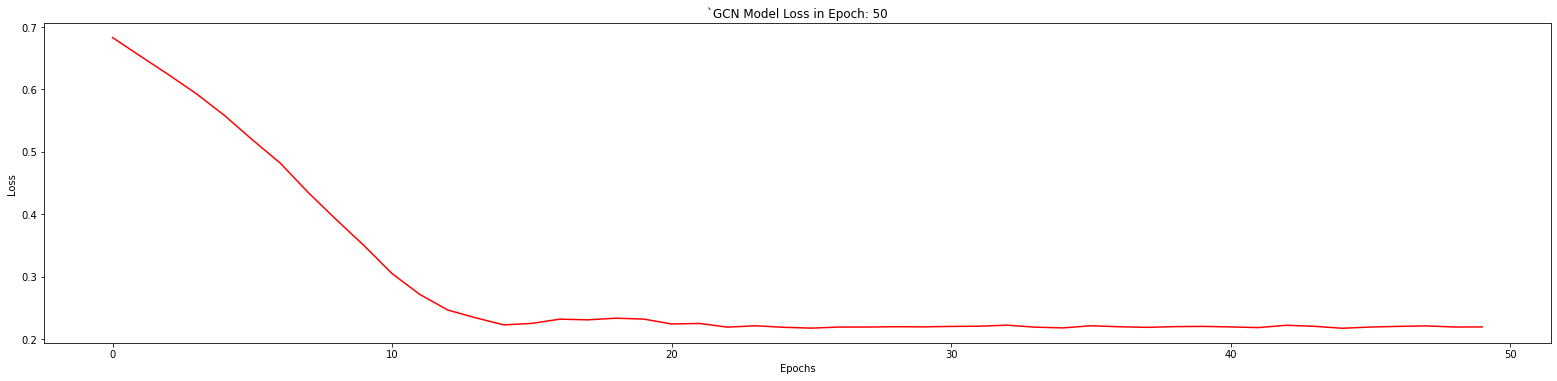

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 051, Evaluation of GNNs Model Loss: 0.2209
Epoch: 052, Evaluation of GNNs Model Loss: 0.2202
Epoch: 053, Evaluation of GNNs Model Loss: 0.2191
Epoch: 054, Evaluation of GNNs Model Loss: 0.2183
Epoch: 055, Evaluation of GNNs Model Loss: 0.2224
Epoch: 056, Evaluation of GNNs Model Loss: 0.2198
Epoch: 057, Evaluation of GNNs Model Loss: 0.2174
Epoch: 058, Evaluation of GNNs Model Loss: 0.2207
Epoch: 059, Evaluation of GNNs Model Loss: 0.2195
Epoch: 060, Evaluation of GNNs Model Loss: 0.2185
Epoch: 061, Evaluation of GNNs Model Loss: 0.2193
Epoch: 062, Evaluation of GNNs Model Loss: 0.2182
Epoch: 063, Evaluation of GNNs Model Loss: 0.2179
Epoch: 064, Evaluation of GNNs Model Loss: 0.2182
Epoch: 065, Evaluation of GNNs Model Loss: 0.2203
Epoch: 066, Evaluation of GNNs Model Loss: 0.2178
Epoch: 067, Evaluation of GNNs Model Loss: 0.2195
Epoch: 068, Evaluation of GNNs Model Loss: 0.2197
Epoch: 069, Evaluation of GNNs Model Loss: 0.2184
Epoch: 070, Evaluation of GNNs Model Loss: 0.2171


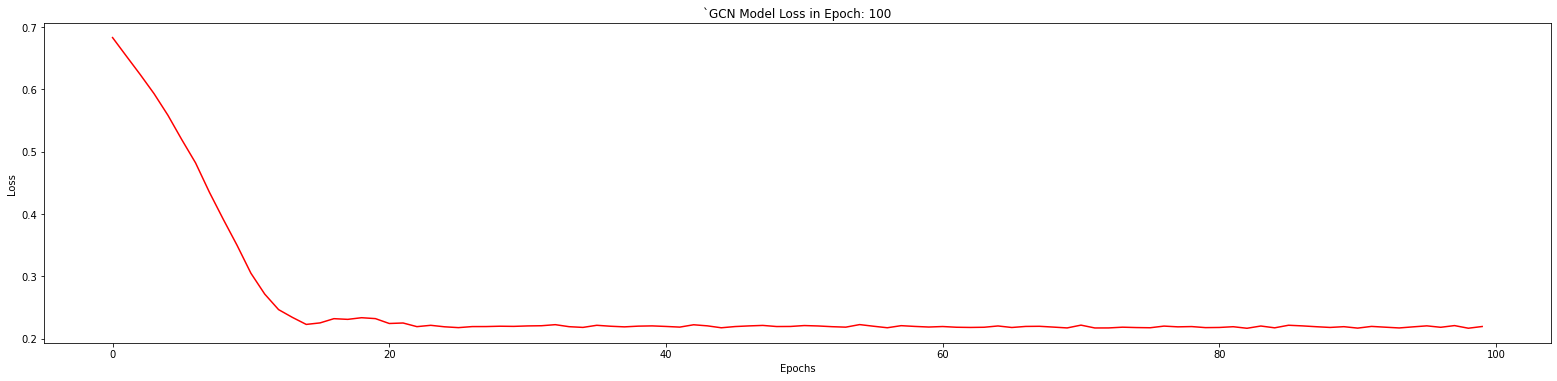

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 101, Evaluation of GNNs Model Loss: 0.2179
Epoch: 102, Evaluation of GNNs Model Loss: 0.2190
Epoch: 103, Evaluation of GNNs Model Loss: 0.2178
Epoch: 104, Evaluation of GNNs Model Loss: 0.2190
Epoch: 105, Evaluation of GNNs Model Loss: 0.2183
Epoch: 106, Evaluation of GNNs Model Loss: 0.2188
Epoch: 107, Evaluation of GNNs Model Loss: 0.2187
Epoch: 108, Evaluation of GNNs Model Loss: 0.2189
Epoch: 109, Evaluation of GNNs Model Loss: 0.2192
Epoch: 110, Evaluation of GNNs Model Loss: 0.2171
Epoch: 111, Evaluation of GNNs Model Loss: 0.2173
Epoch: 112, Evaluation of GNNs Model Loss: 0.2186
Epoch: 113, Evaluation of GNNs Model Loss: 0.2190
Epoch: 114, Evaluation of GNNs Model Loss: 0.2157
Epoch: 115, Evaluation of GNNs Model Loss: 0.2182
Epoch: 116, Evaluation of GNNs Model Loss: 0.2159
Epoch: 117, Evaluation of GNNs Model Loss: 0.2185
Epoch: 118, Evaluation of GNNs Model Loss: 0.2191
Epoch: 119, Evaluation of GNNs Model Loss: 0.2182
Epoch: 120, Evaluation of GNNs Model Loss: 0.2192


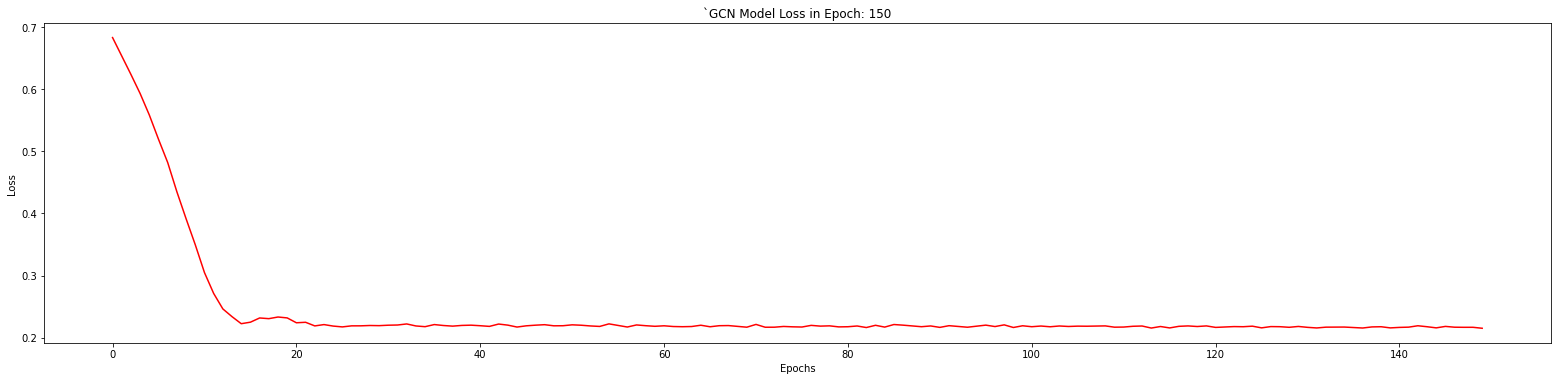

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 151, Evaluation of GNNs Model Loss: 0.2176
Epoch: 152, Evaluation of GNNs Model Loss: 0.2162
Epoch: 153, Evaluation of GNNs Model Loss: 0.2162
Epoch: 154, Evaluation of GNNs Model Loss: 0.2170
Epoch: 155, Evaluation of GNNs Model Loss: 0.2166
Epoch: 156, Evaluation of GNNs Model Loss: 0.2164
Epoch: 157, Evaluation of GNNs Model Loss: 0.2175
Epoch: 158, Evaluation of GNNs Model Loss: 0.2180
Epoch: 159, Evaluation of GNNs Model Loss: 0.2180
Epoch: 160, Evaluation of GNNs Model Loss: 0.2178
Epoch: 161, Evaluation of GNNs Model Loss: 0.2204
Epoch: 162, Evaluation of GNNs Model Loss: 0.2193
Epoch: 163, Evaluation of GNNs Model Loss: 0.2175
Epoch: 164, Evaluation of GNNs Model Loss: 0.2187
Epoch: 165, Evaluation of GNNs Model Loss: 0.2171
Epoch: 166, Evaluation of GNNs Model Loss: 0.2162
Epoch: 167, Evaluation of GNNs Model Loss: 0.2174
Epoch: 168, Evaluation of GNNs Model Loss: 0.2176
Epoch: 169, Evaluation of GNNs Model Loss: 0.2181
Epoch: 170, Evaluation of GNNs Model Loss: 0.2167


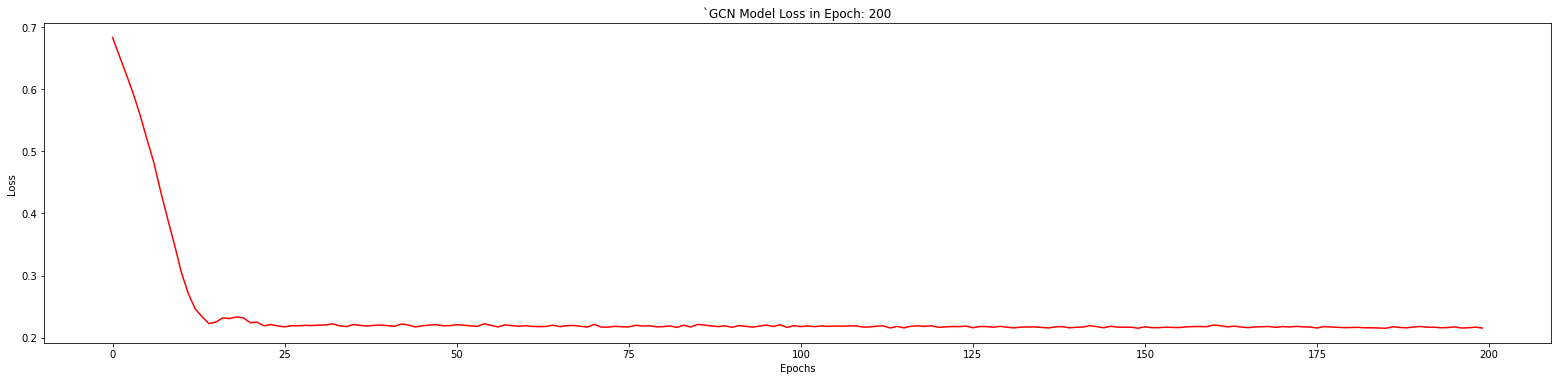

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 001, Evaluation of GNNs Model Loss: 0.6332
Epoch: 002, Evaluation of GNNs Model Loss: 0.5885
Epoch: 003, Evaluation of GNNs Model Loss: 0.5493
Epoch: 004, Evaluation of GNNs Model Loss: 0.5158
Epoch: 005, Evaluation of GNNs Model Loss: 0.4759
Epoch: 006, Evaluation of GNNs Model Loss: 0.4394
Epoch: 007, Evaluation of GNNs Model Loss: 0.4016
Epoch: 008, Evaluation of GNNs Model Loss: 0.3709
Epoch: 009, Evaluation of GNNs Model Loss: 0.3380
Epoch: 010, Evaluation of GNNs Model Loss: 0.3086
Epoch: 011, Evaluation of GNNs Model Loss: 0.2790
Epoch: 012, Evaluation of GNNs Model Loss: 0.2642
Epoch: 013, Evaluation of GNNs Model Loss: 0.2500
Epoch: 014, Evaluation of GNNs Model Loss: 0.2427
Epoch: 015, Evaluation of GNNs Model Loss: 0.2393
Epoch: 016, Evaluation of GNNs Model Loss: 0.2407
Epoch: 017, Evaluation of GNNs Model Loss: 0.2420
Epoch: 018, Evaluation of GNNs Model Loss: 0.2464
Epoch: 019, Evaluation of GNNs Model Loss: 0.2433
Epoch: 020, Evaluation of GNNs Model Loss: 0.2483


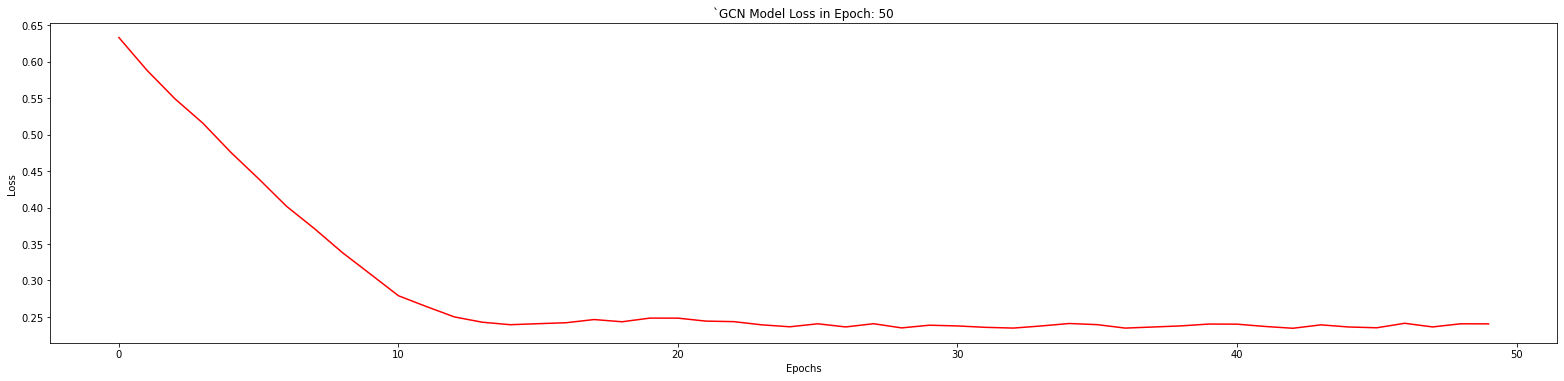

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 051, Evaluation of GNNs Model Loss: 0.2363
Epoch: 052, Evaluation of GNNs Model Loss: 0.2363
Epoch: 053, Evaluation of GNNs Model Loss: 0.2351
Epoch: 054, Evaluation of GNNs Model Loss: 0.2359
Epoch: 055, Evaluation of GNNs Model Loss: 0.2418
Epoch: 056, Evaluation of GNNs Model Loss: 0.2360
Epoch: 057, Evaluation of GNNs Model Loss: 0.2412
Epoch: 058, Evaluation of GNNs Model Loss: 0.2386
Epoch: 059, Evaluation of GNNs Model Loss: 0.2328
Epoch: 060, Evaluation of GNNs Model Loss: 0.2384
Epoch: 061, Evaluation of GNNs Model Loss: 0.2363
Epoch: 062, Evaluation of GNNs Model Loss: 0.2366
Epoch: 063, Evaluation of GNNs Model Loss: 0.2369
Epoch: 064, Evaluation of GNNs Model Loss: 0.2394
Epoch: 065, Evaluation of GNNs Model Loss: 0.2341
Epoch: 066, Evaluation of GNNs Model Loss: 0.2351
Epoch: 067, Evaluation of GNNs Model Loss: 0.2344
Epoch: 068, Evaluation of GNNs Model Loss: 0.2334
Epoch: 069, Evaluation of GNNs Model Loss: 0.2385
Epoch: 070, Evaluation of GNNs Model Loss: 0.2385


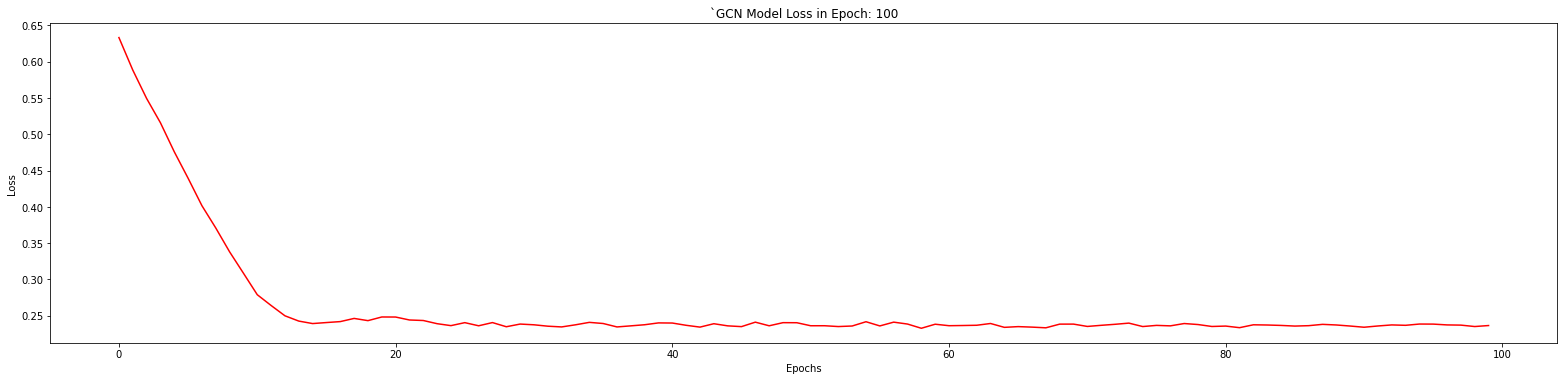

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 101, Evaluation of GNNs Model Loss: 0.2358
Epoch: 102, Evaluation of GNNs Model Loss: 0.2355
Epoch: 103, Evaluation of GNNs Model Loss: 0.2374
Epoch: 104, Evaluation of GNNs Model Loss: 0.2375
Epoch: 105, Evaluation of GNNs Model Loss: 0.2346
Epoch: 106, Evaluation of GNNs Model Loss: 0.2360
Epoch: 107, Evaluation of GNNs Model Loss: 0.2339
Epoch: 108, Evaluation of GNNs Model Loss: 0.2349
Epoch: 109, Evaluation of GNNs Model Loss: 0.2355
Epoch: 110, Evaluation of GNNs Model Loss: 0.2330
Epoch: 111, Evaluation of GNNs Model Loss: 0.2358
Epoch: 112, Evaluation of GNNs Model Loss: 0.2343
Epoch: 113, Evaluation of GNNs Model Loss: 0.2369
Epoch: 114, Evaluation of GNNs Model Loss: 0.2399
Epoch: 115, Evaluation of GNNs Model Loss: 0.2356
Epoch: 116, Evaluation of GNNs Model Loss: 0.2353
Epoch: 117, Evaluation of GNNs Model Loss: 0.2363
Epoch: 118, Evaluation of GNNs Model Loss: 0.2348
Epoch: 119, Evaluation of GNNs Model Loss: 0.2344
Epoch: 120, Evaluation of GNNs Model Loss: 0.2356


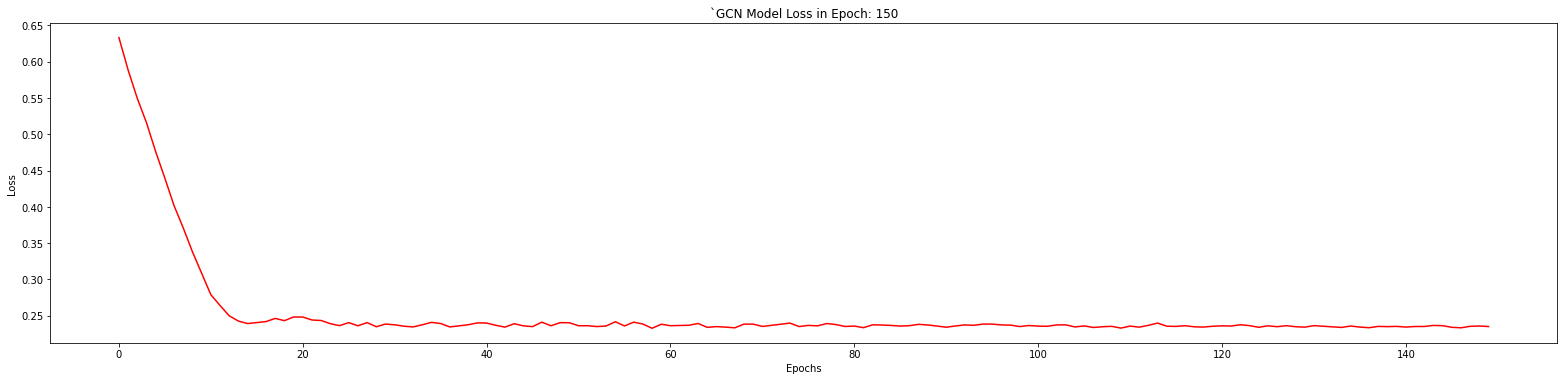

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 151, Evaluation of GNNs Model Loss: 0.2346
Epoch: 152, Evaluation of GNNs Model Loss: 0.2327
Epoch: 153, Evaluation of GNNs Model Loss: 0.2354
Epoch: 154, Evaluation of GNNs Model Loss: 0.2342
Epoch: 155, Evaluation of GNNs Model Loss: 0.2336
Epoch: 156, Evaluation of GNNs Model Loss: 0.2340
Epoch: 157, Evaluation of GNNs Model Loss: 0.2347
Epoch: 158, Evaluation of GNNs Model Loss: 0.2351
Epoch: 159, Evaluation of GNNs Model Loss: 0.2350
Epoch: 160, Evaluation of GNNs Model Loss: 0.2338
Epoch: 161, Evaluation of GNNs Model Loss: 0.2347
Epoch: 162, Evaluation of GNNs Model Loss: 0.2350
Epoch: 163, Evaluation of GNNs Model Loss: 0.2353
Epoch: 164, Evaluation of GNNs Model Loss: 0.2341
Epoch: 165, Evaluation of GNNs Model Loss: 0.2330
Epoch: 166, Evaluation of GNNs Model Loss: 0.2346
Epoch: 167, Evaluation of GNNs Model Loss: 0.2327
Epoch: 168, Evaluation of GNNs Model Loss: 0.2332
Epoch: 169, Evaluation of GNNs Model Loss: 0.2351
Epoch: 170, Evaluation of GNNs Model Loss: 0.2336


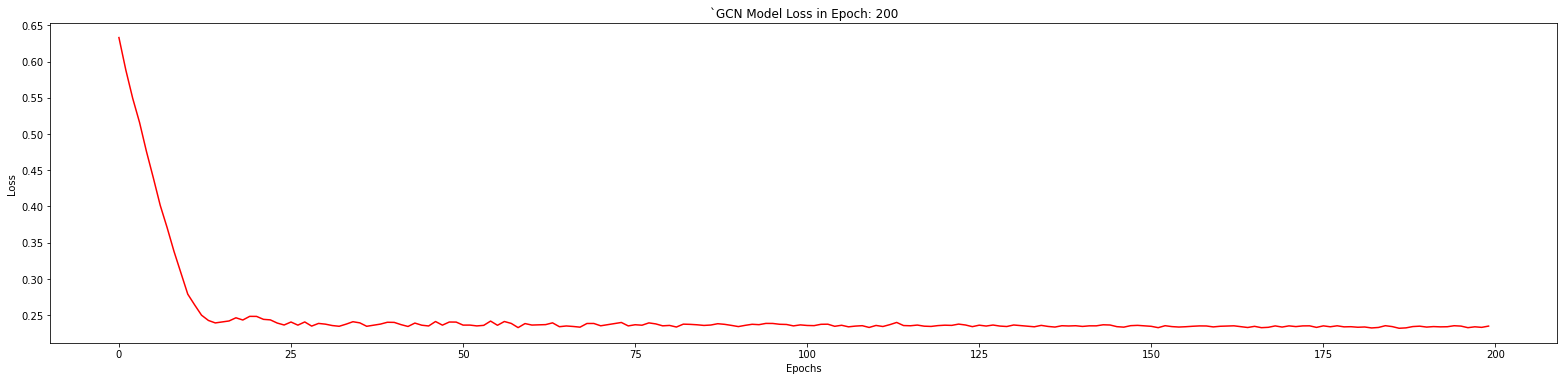

iTeration: 004 is Passed!
Best result: {'Batch_count_by_16': 1.0, 'Bias': 1.0, 'Dataset_name': 1.0, 'DropOut_Rate': 0.33192112070234936, 'EPOCHS': 200.0, 'Loss_Function': 1.0, 'Model_name': 1.0, 'Weight_Initializer': 1.0, 'load_index': 0.0, 'lr': 0.004417851804109998, 'num_folds': 3.0}; f(x) = 0.844.




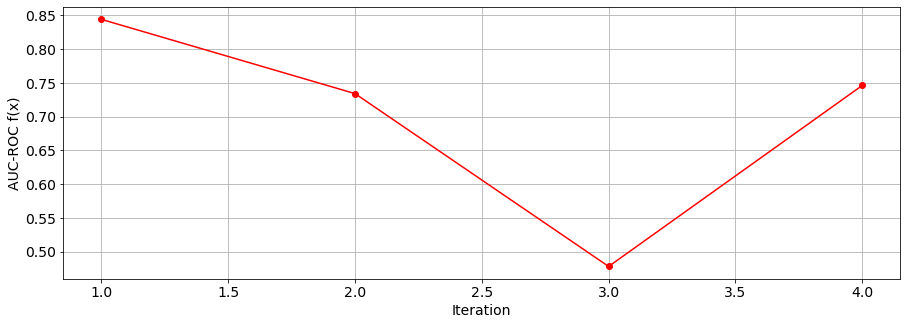

In [ ]:
call_me_to_start(4)

Best result: {'Batch_count_by_16': 1.0, 'Bias': 1.0, 'Dataset_name': 1.0, 'DropOut_Rate': 0.33192112070234936, 'EPOCHS': 200.0, 'Loss_Function': 1.0, 'Model_name': 1.0, 'Weight_Initializer': 1.0, 'load_index': 0.0, 'lr': 0.004417851804109998, 'num_folds': 3.0}; f(x) = 0.844.


[0.84404762 0.7340368  0.47796818 0.74615385]


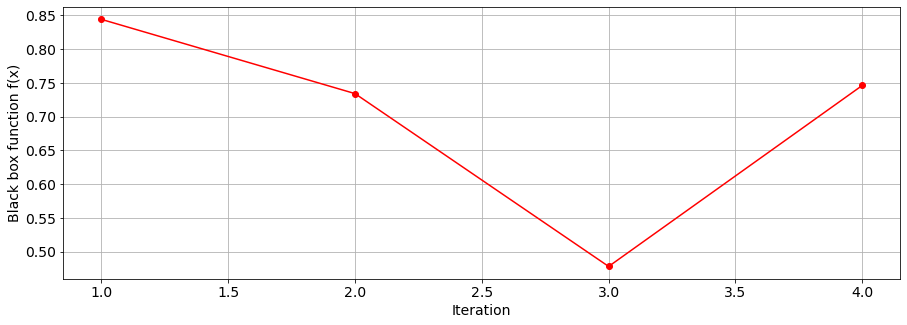

In [ ]:
print("Best result: {}; f(x) = {:.3f}.".format(optimizer.max["params"], optimizer.max["target"]))
print()
print()
plt.figure(figsize = (15, 5))
print(optimizer.space.target)
plt.plot(range(1, 1 + len(optimizer.space.target)), optimizer.space.target, "-o", color='red')
plt.grid(True)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Black box function f(x)", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [ ]:
optimizer.maximize(init_points = 1, n_iter = 2)

|   iter    |  target   |   Batch   |   Bias    | Datase... | DropOu... |  EPOCHS   | Loss_F... | Model_... | Weight... | load_i... |    lr     | num_folds |
-------------------------------------------------------------------------------------------------------------------------------------------------------------


TypeError: ignored

In [ ]:
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

Best result: {'DropOut_Rate': 0.4931529940725688}; f(x) = 0.8088541666666667.


In [ ]:
from sklearn.model_selection import GridSearchCV
max_folds = np.arange(1,3,1)
param_grid = dict(max_folds=max_folds)
grid = GridSearchCV(estimator=Central_Room, param_grid=param_grid, cv=5)
grid.fit()

TypeError: ignored

# **Test Configuration for the Model**

In [ ]:
fpr, tpr, threshold, precision_list, npv_list, acc_list, f1score_list, auc_roc2, auc_prc2, acc, acc2 = Evaluations(np.array(Real_labels), np.array(Predicted_Labels))

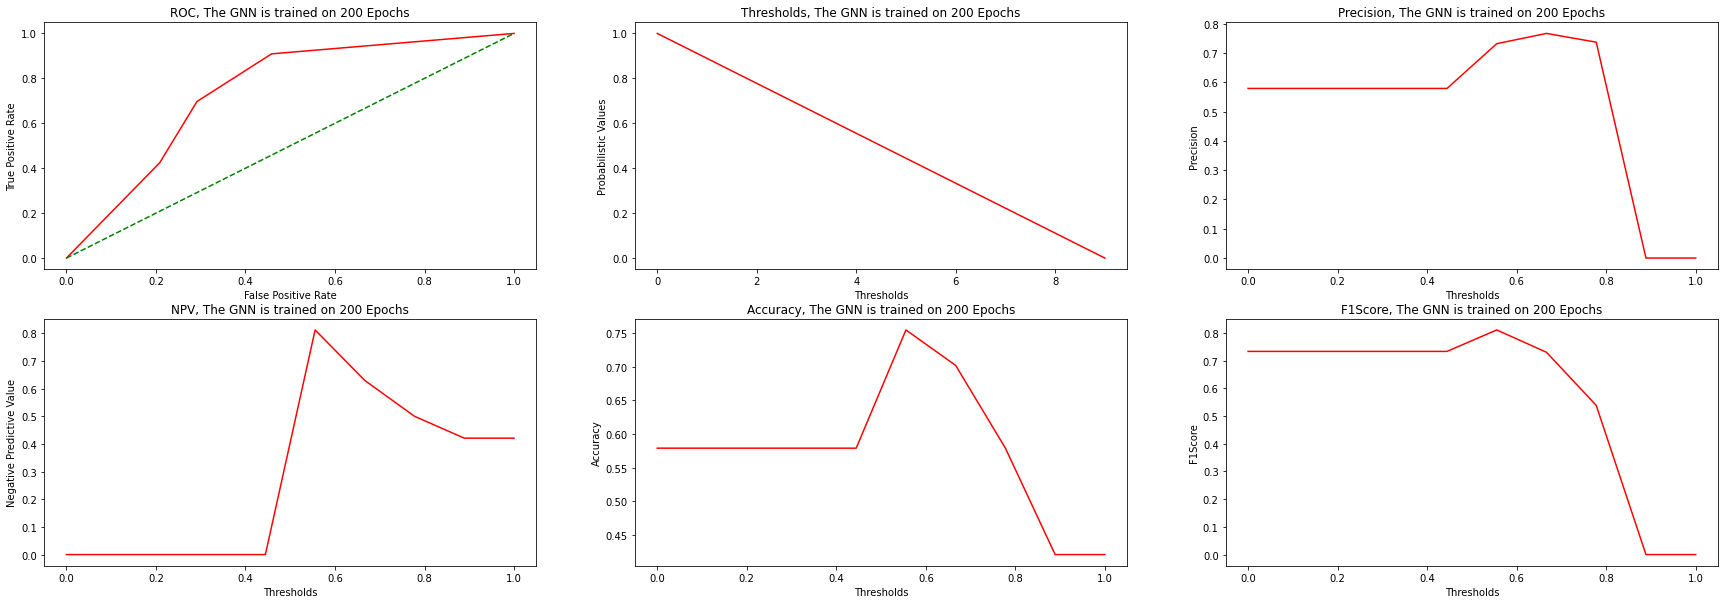

In [ ]:
#                   fpr, tpr, threshold, precision_list, npv_list, acc_list, f1score_list
Evaluation_Plots([fpr, tpr, threshold, precision_list, npv_list, acc_list, f1score_list])

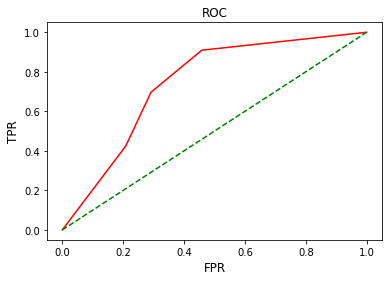

In [ ]:
plt.plot(fpr, tpr, 'r')
plt.plot([0,1],[0,1], 'g--')
plt.title("ROC")
plt.xlabel("FPR", fontsize=12)
plt.ylabel("TPR", fontsize=12)

plt.show()

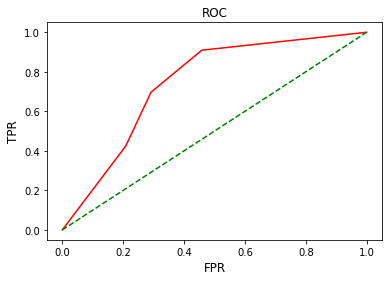

In [ ]:
plt.plot(fpr, tpr, 'r')
plt.plot([0,1],[0,1], 'g--')
plt.title("ROC")
plt.xlabel("FPR", fontsize=12)
plt.ylabel("TPR", fontsize=12)

plt.show()

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(real_labels, real_labels)

In [ ]:
print(fpr, tpr)
print(thresholds)

[0. 0. 1.] [0. 1. 1.]
[2 1 0]


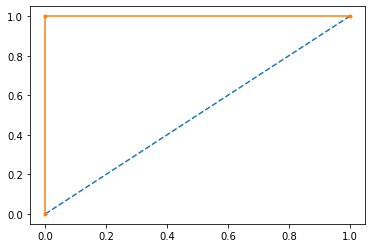

In [ ]:
from matplotlib import pyplot
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')

In [ ]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  GCN_Model, GCN_Model_Optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index, GCN_Model_1, GCN_Model_Optimizer_1, Train_Dataset1)